### Train the NGBoost model

Implementation of [LightGBMTrainer](https://github.com/HealthRex/healthrex_ml/blob/main/healthrex_ml/trainers/sklearn_trainers.py#L23)

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import scipy
import math

from healthrex_ml.trainers import LightGBMTrainer
from healthrex_ml.trainers import NGBoostTrainer
from healthrex_ml.evaluators import BinaryEvaluator

In [2]:
RUN_NAME = "20230218_jyx_cbc"
trainer = NGBoostTrainer(working_dir=f"./{RUN_NAME}_artifacts")
tasks = ['label_PLT', 'label_HCT', 'label_WBC', 'label_HGB']

# for task in tasks:
#     trainer(task)

### Evaluate model performance on test set and dump 

Implementation of [BinaryEvaluator](https://github.com/HealthRex/healthrex_ml/blob/main/healthrex_ml/evaluators/evaluators.py#L21) NPVEvaluator

In [3]:
def NPV_eval(prev_measure, cur_measure, y_mean, y_dist, task, pred_type='stable'):
    task_name = task.split('_')[1]
    task2thres =  {'WBC': 1.75, 'HGB': 1.0, 'HCT': 3.0, 'PLT': 62.5, \
            'NA': 2.5, 'K': 0.5, 'CR': 0.125, 'CA': 0.525, 'ALB': 0.425} 
    upper_lim = prev_measure + task2thres[task_name]
    lower_lim = prev_measure - task2thres[task_name]
    if pred_type == 'stable':
        binary_labels = ((cur_measure>=lower_lim)&(cur_measure<=upper_lim))
        prediction_prob = 0.5 * (scipy.special.erf((upper_lim - y_mean)/(math.sqrt(2)*y_dist)) - scipy.special.erf((lower_lim - y_mean)/(math.sqrt(2)*y_dist)))
    elif pred_type == 'higher':
        binary_labels = (cur_measure>upper_lim)
        prediction_prob = 1 - 0.5 * (1 + scipy.special.erf((upper_lim - y_mean)/(math.sqrt(2)*y_dist)))
    elif pred_type == 'lower':
        binary_labels = (cur_measure<lower_lim)
        prediction_prob = 0.5 * (1 + scipy.special.erf((lower_lim - y_mean)/(math.sqrt(2)*y_dist)))
    else:
        raise NotImplementedError
    return binary_labels, prediction_prob

In [4]:
def temp_scaling(prediction_prob, scale=1):
    return np.minimum(1, prediction_prob * scale)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:37<00:00, 24.35s/it]


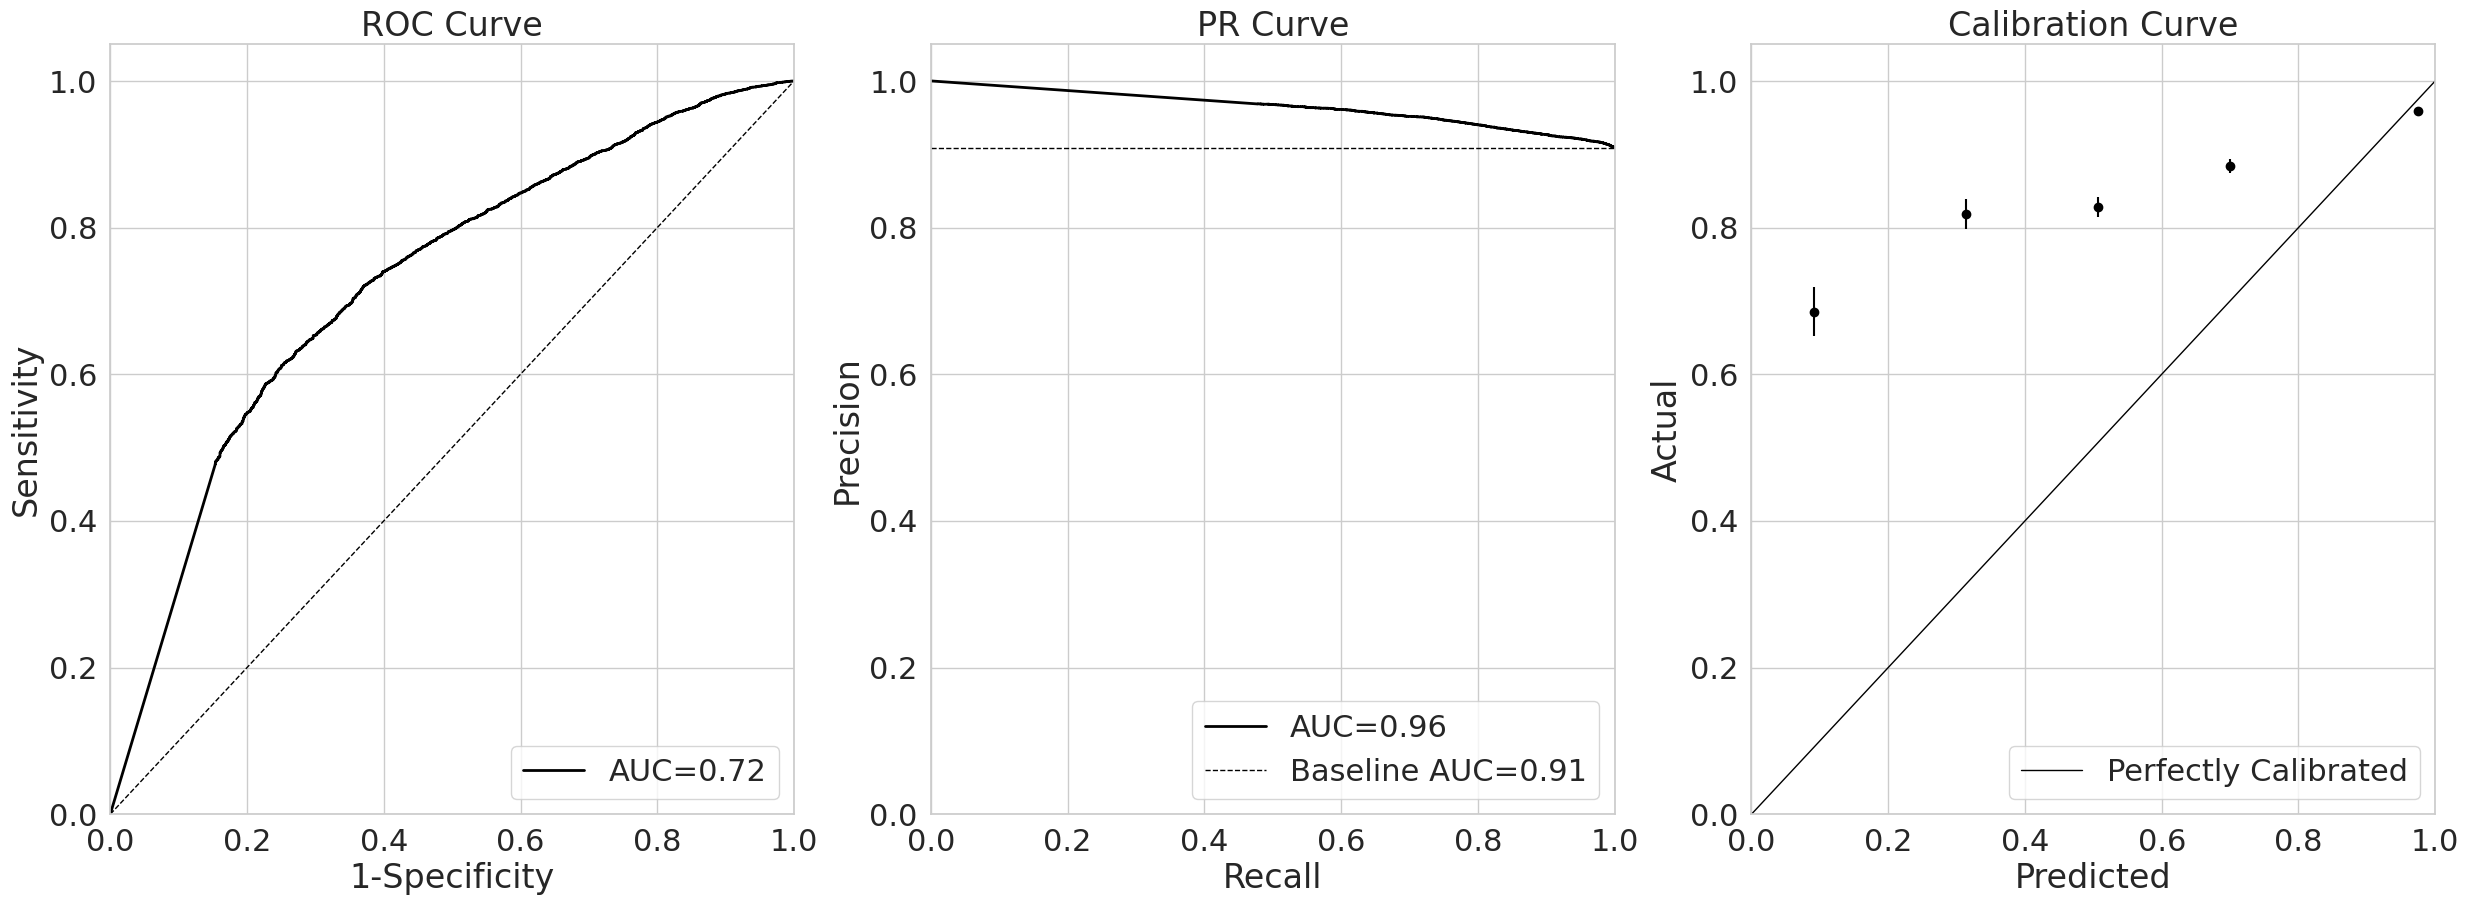

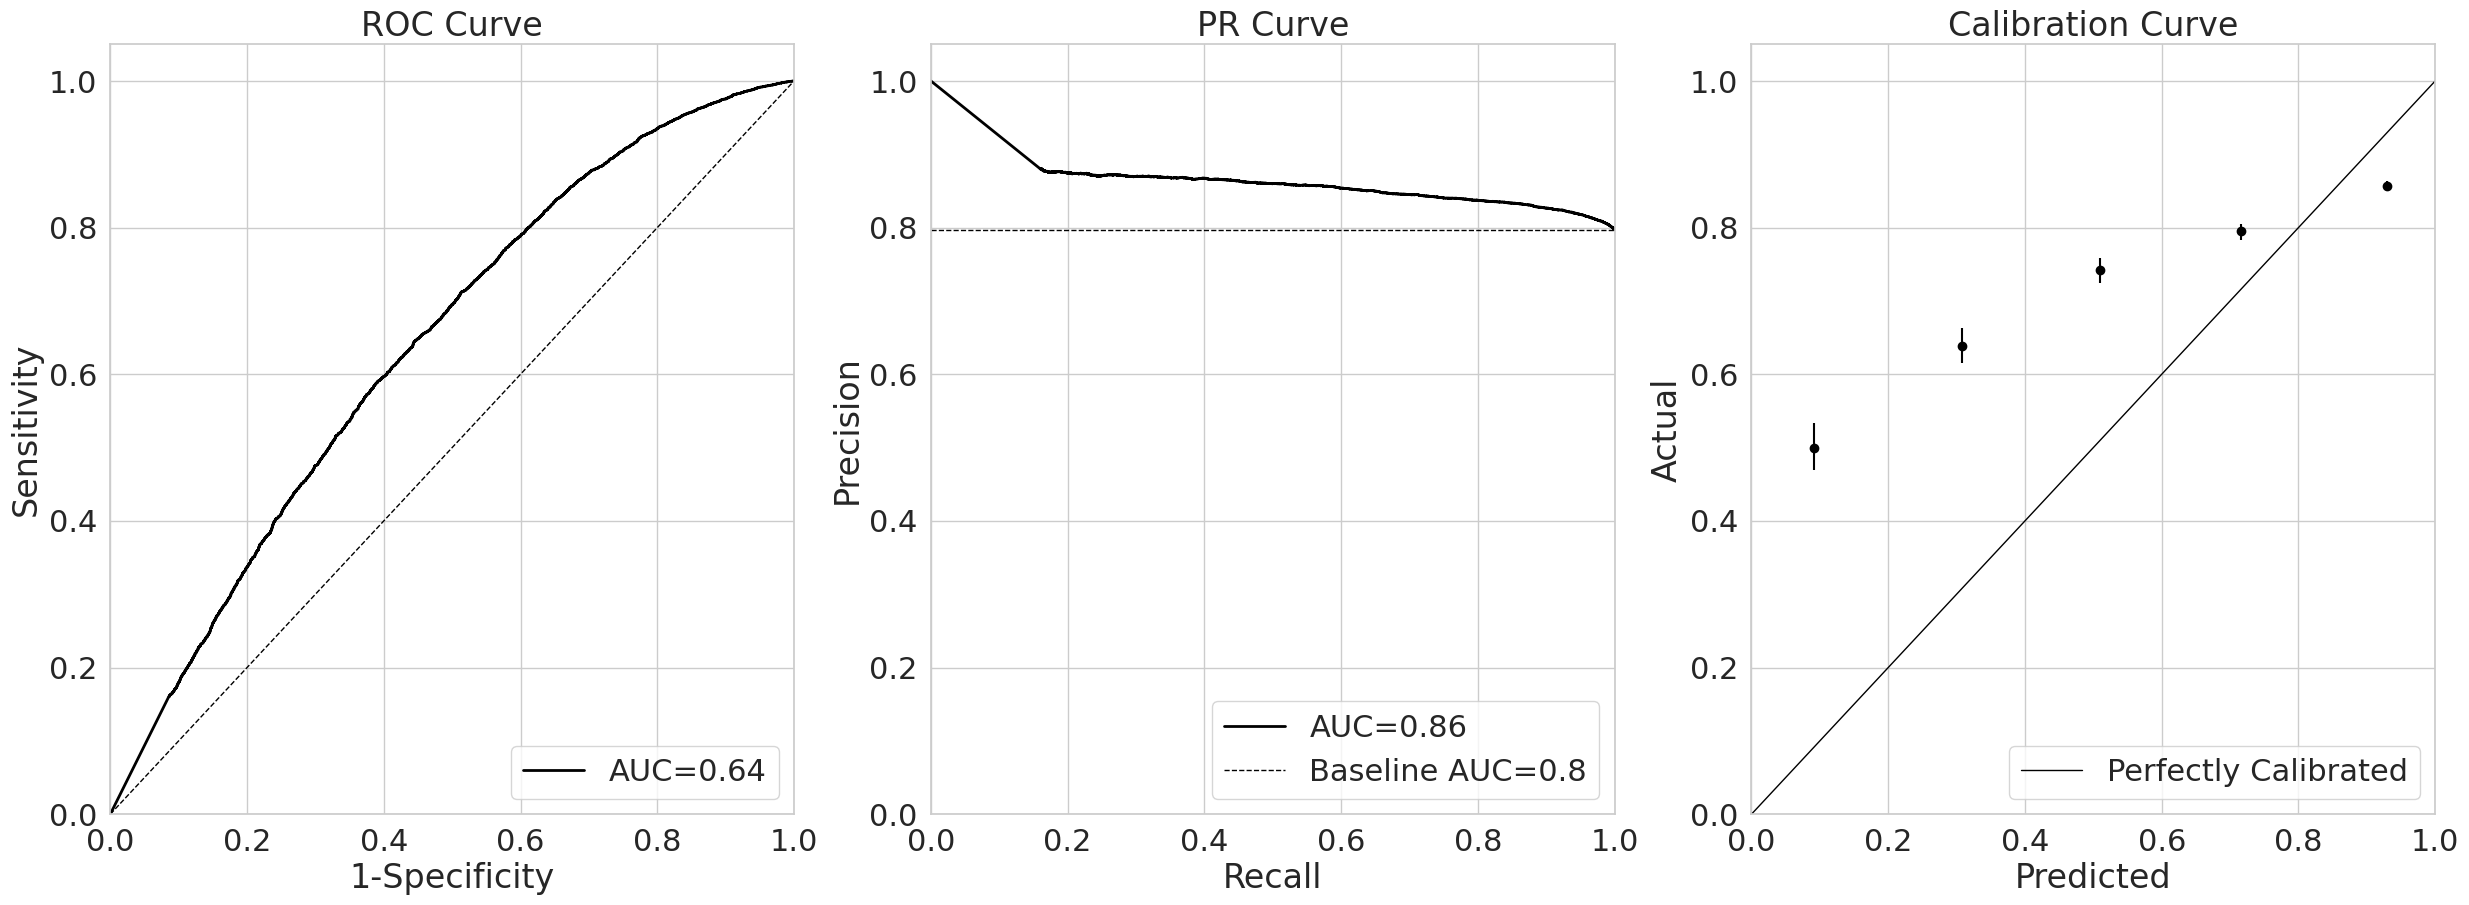

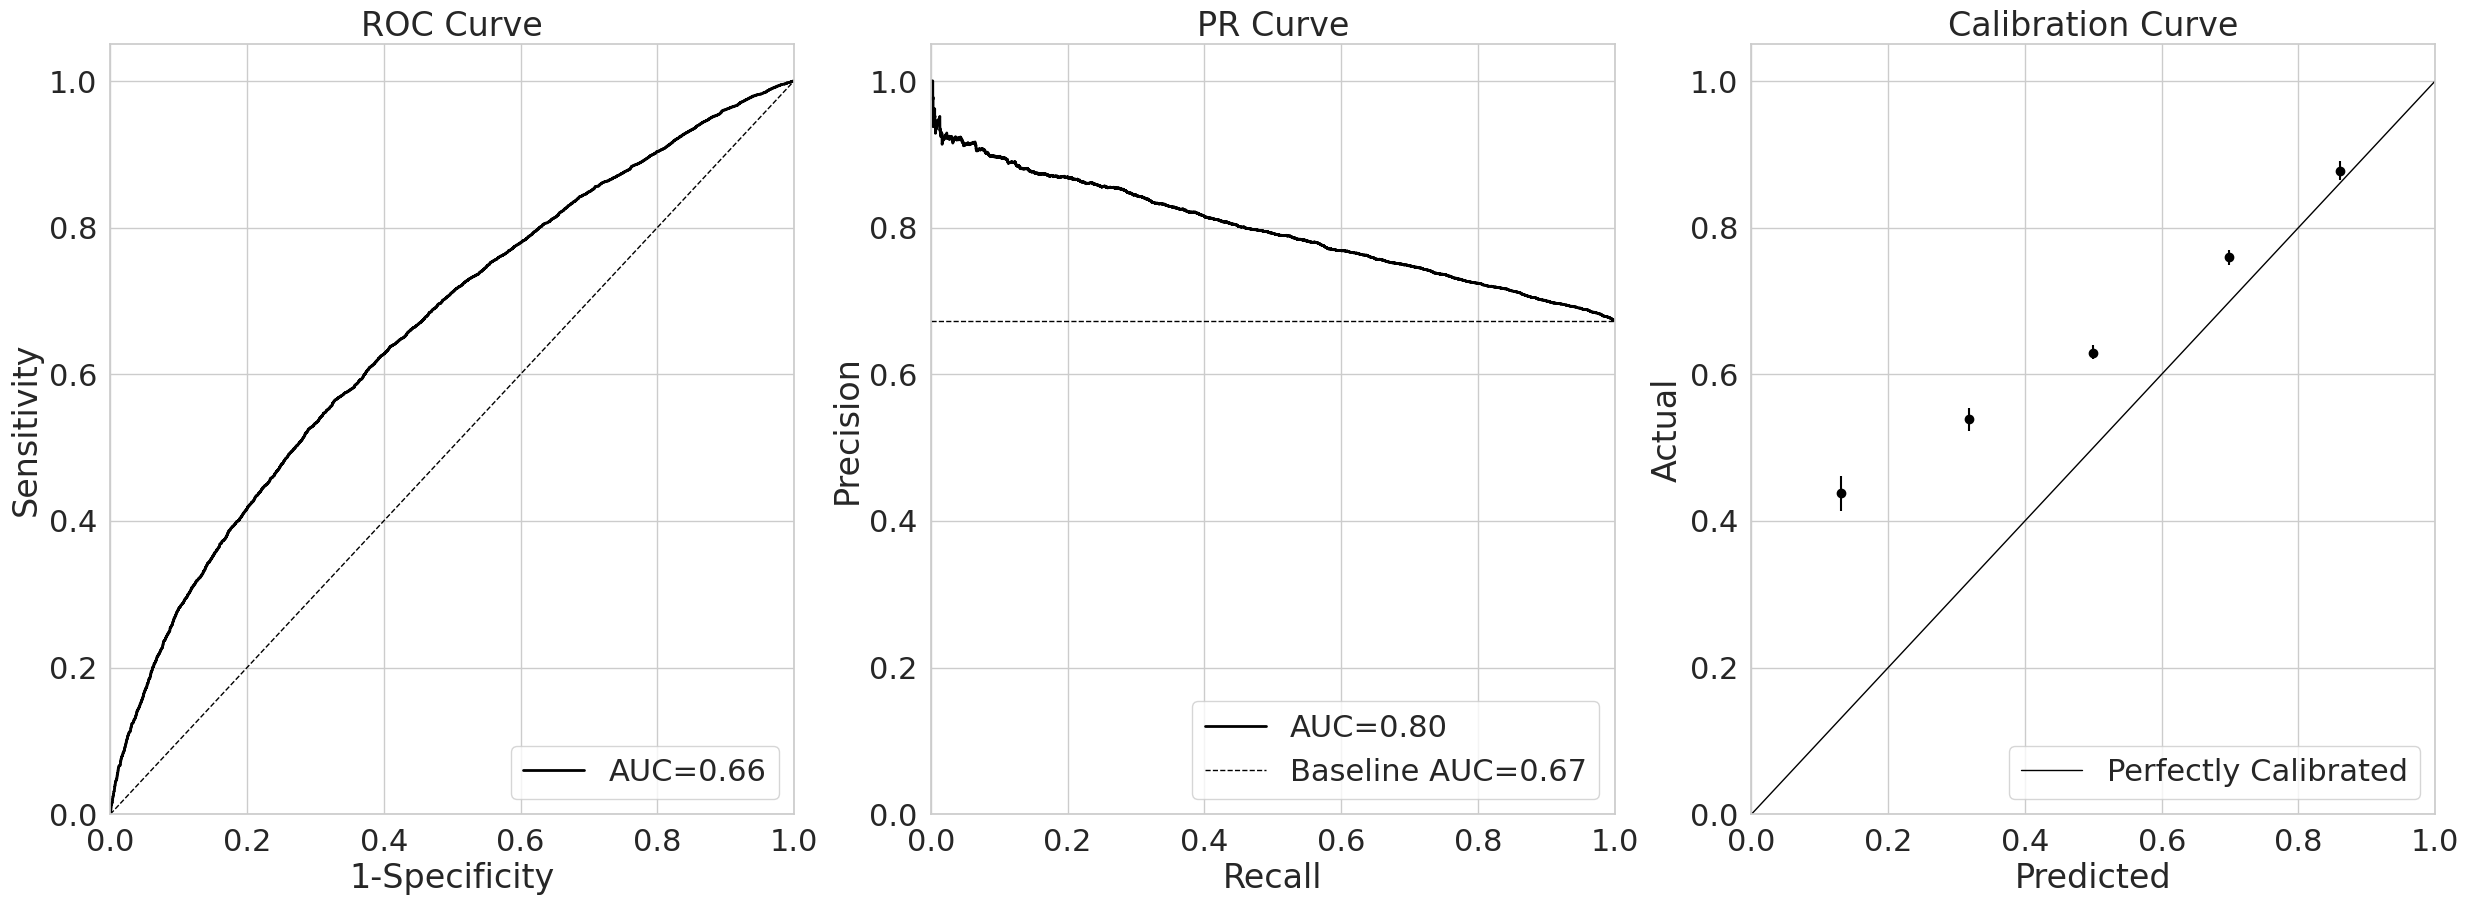

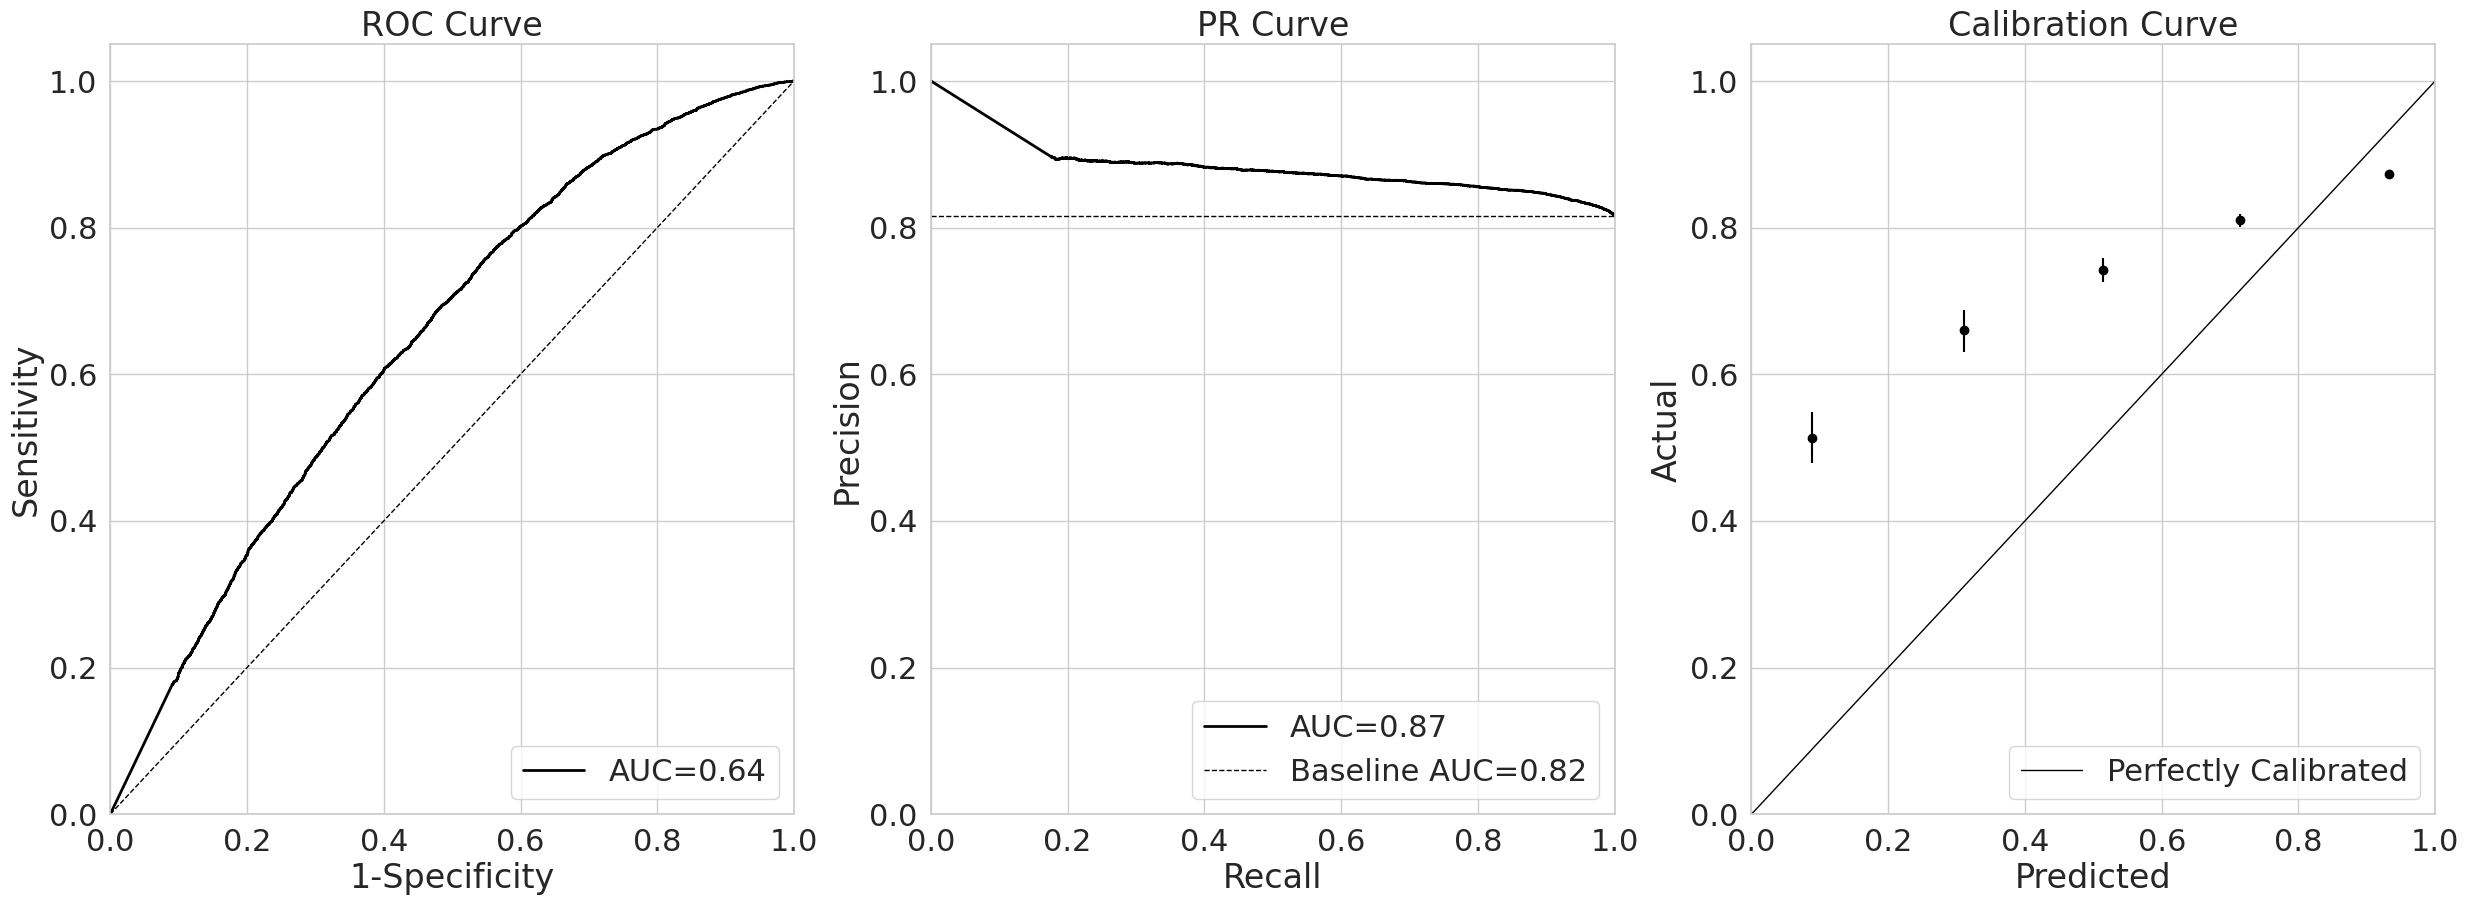

In [5]:
# with temperature scaling
for task in tqdm(tasks):
    evalr = BinaryEvaluator(
        outdir=f"./{RUN_NAME}_artifacts/{task}_performance_artificats/",
        task_name=task
    )
    df_yhats = pd.read_csv(os.path.join(trainer.working_dir, f"{task}_regression_yhats.csv"))
    binary_labels, prediction_prob = NPV_eval(df_yhats.last_labels, df_yhats.labels, df_yhats.predictions,\
                                              df_yhats.distribution_norm, task, pred_type='stable')
    prediction_prob = temp_scaling(prediction_prob, scale=1.4)
    evalr(binary_labels, prediction_prob)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:40<00:00, 25.23s/it]


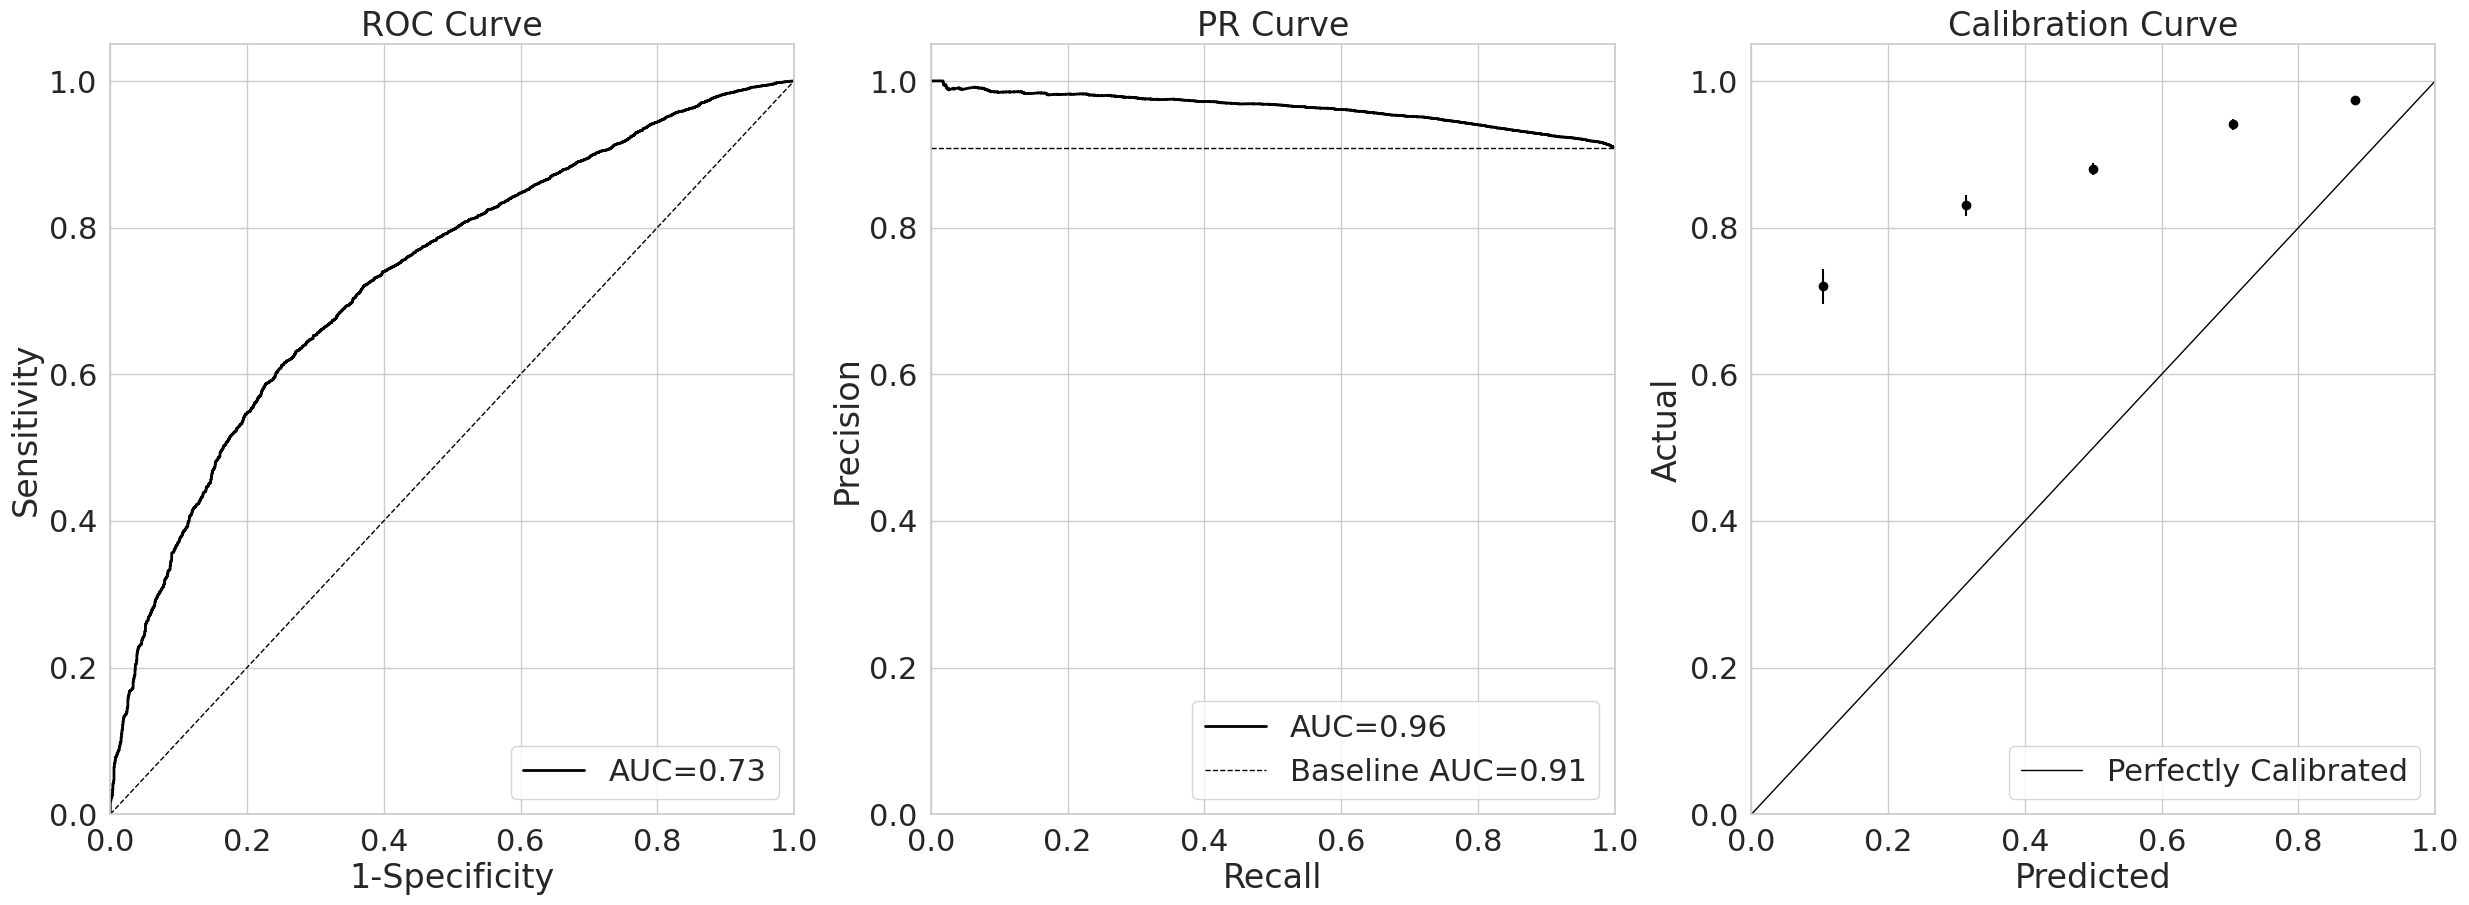

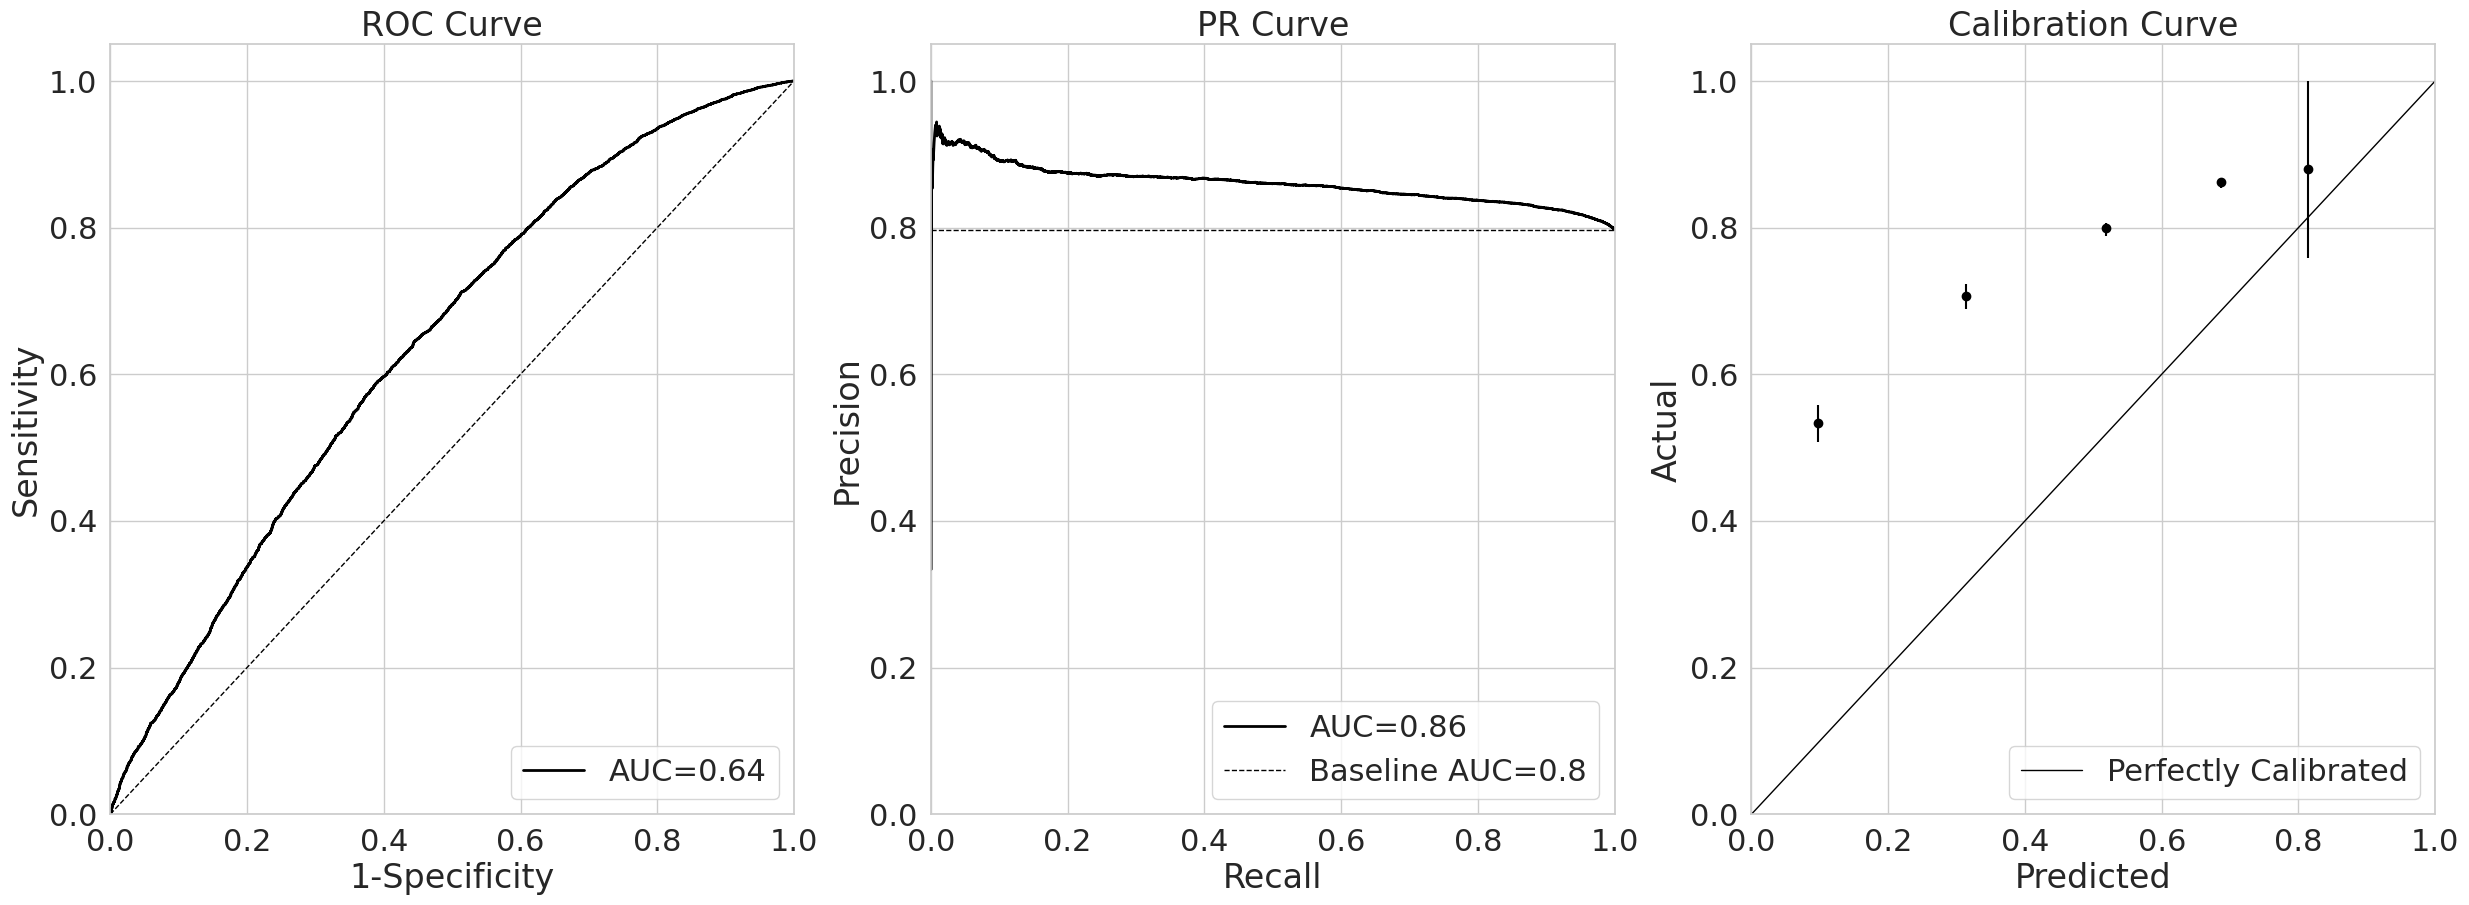

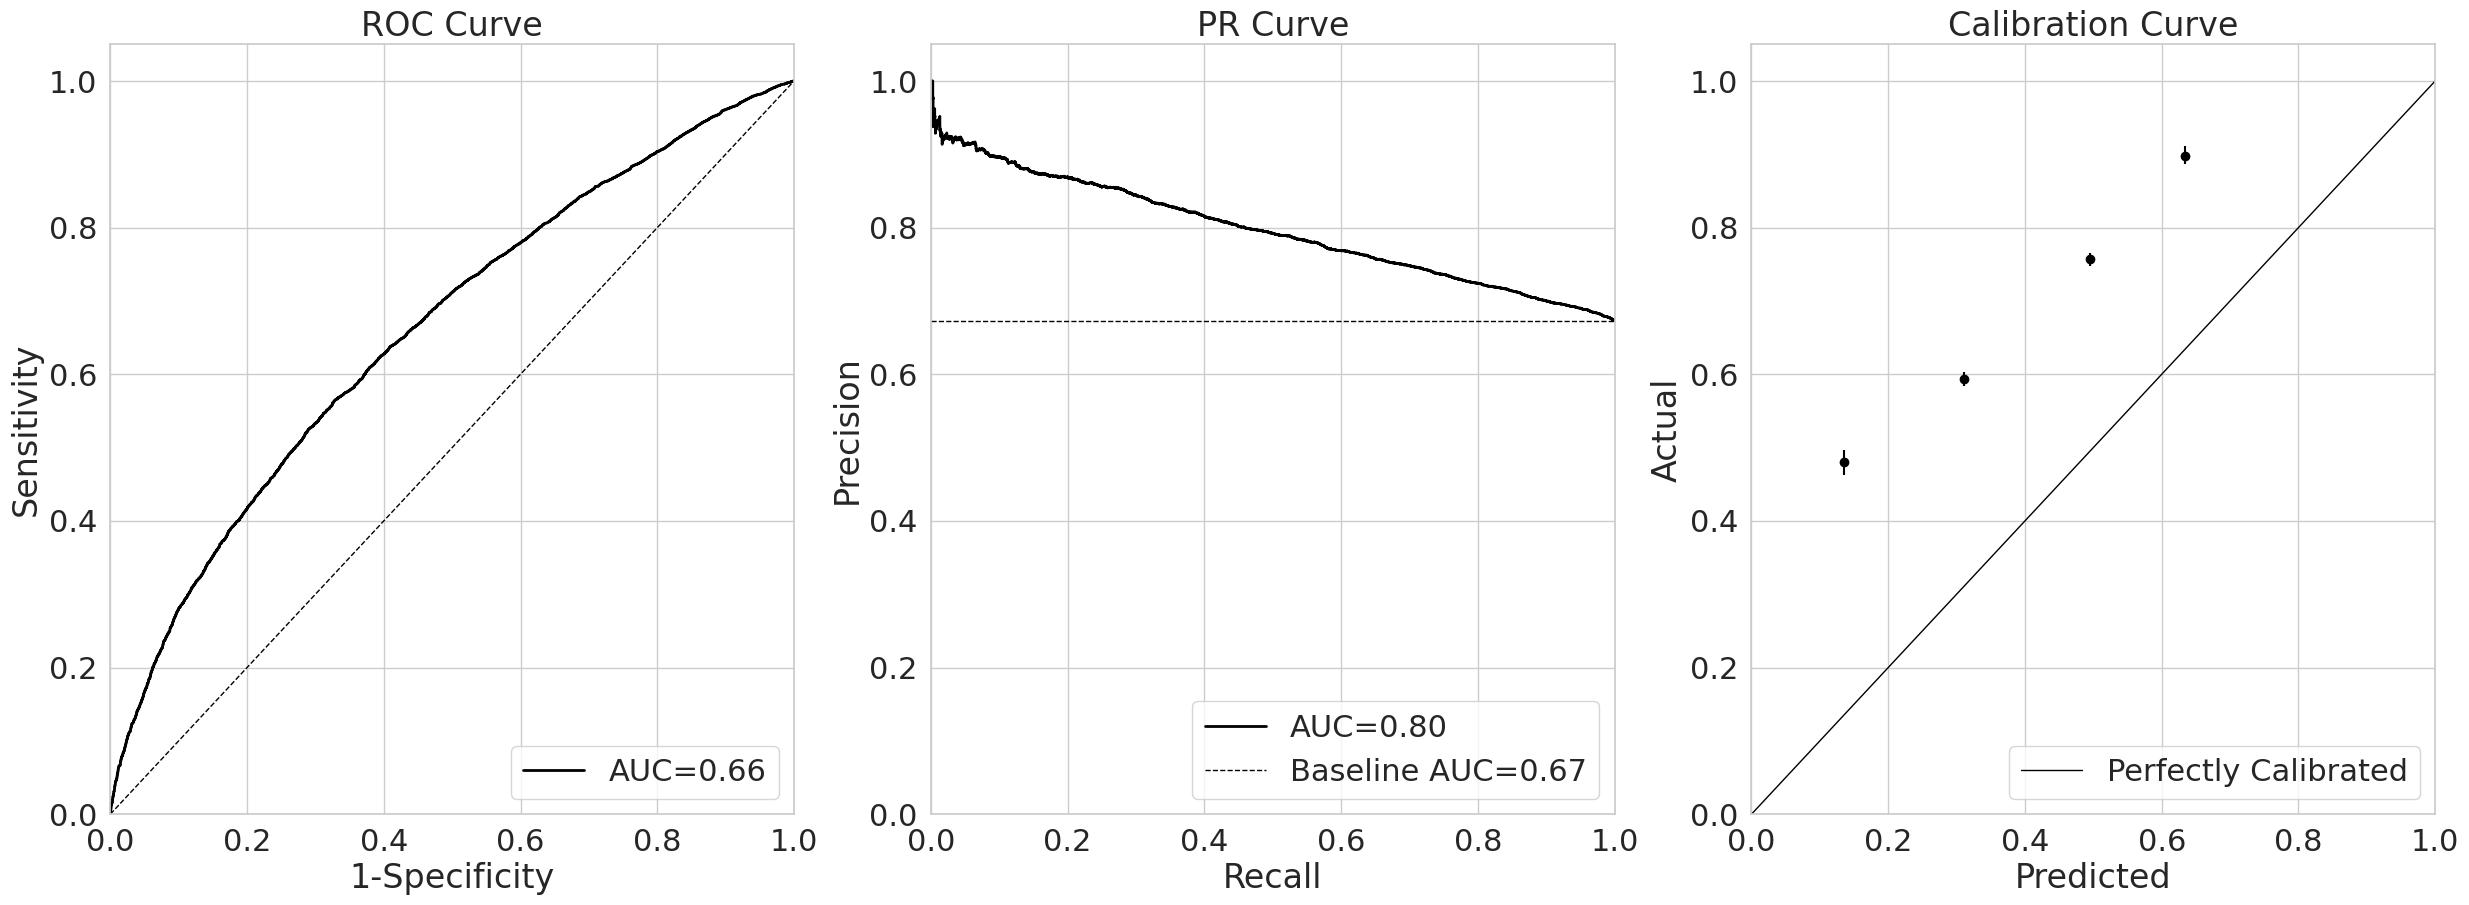

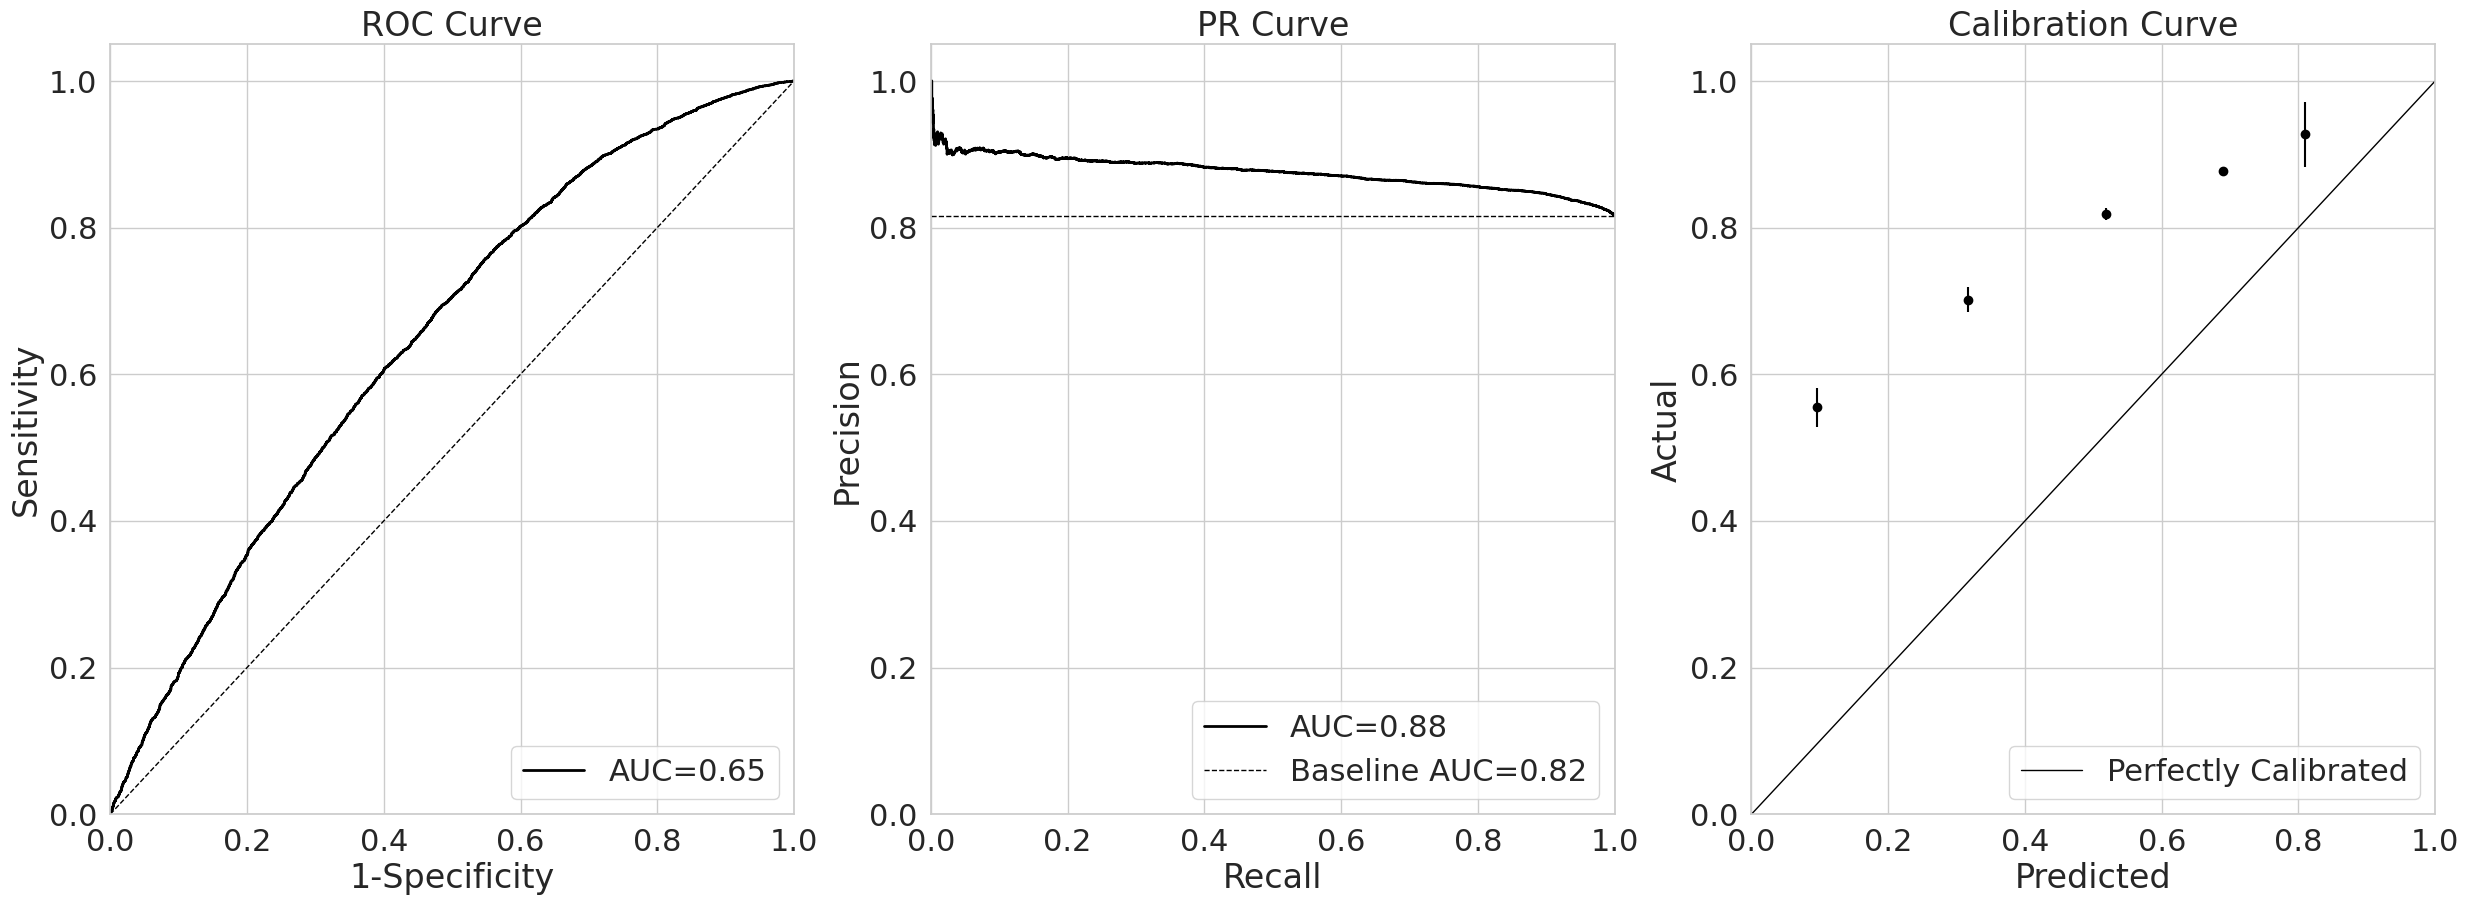

In [6]:
# without temperature scaling
for task in tqdm(tasks):
    evalr = BinaryEvaluator(
        outdir=f"./{RUN_NAME}_artifacts/{task}_performance_artificats/",
        task_name=task
    )
    df_yhats = pd.read_csv(os.path.join(trainer.working_dir, f"{task}_regression_yhats.csv"))
    binary_labels, prediction_prob = NPV_eval(df_yhats.last_labels, df_yhats.labels, df_yhats.predictions,\
                                              df_yhats.distribution_norm, task, pred_type='stable')
    prediction_prob = temp_scaling(prediction_prob)
    evalr(binary_labels, prediction_prob)

### Train the LightGBM model for baseline

In [8]:
RUN_NAME = "20230218_jyx_cbc"
trainer = LightGBMTrainer(working_dir=f"./{RUN_NAME}_artifacts")
tasks = ['label_PLT', 'label_HCT', 'label_WBC', 'label_HGB']

# for task in tasks:
#     trainer(task, True)

### Evaluate model performance on test set and dump 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:32<00:00, 23.23s/it]


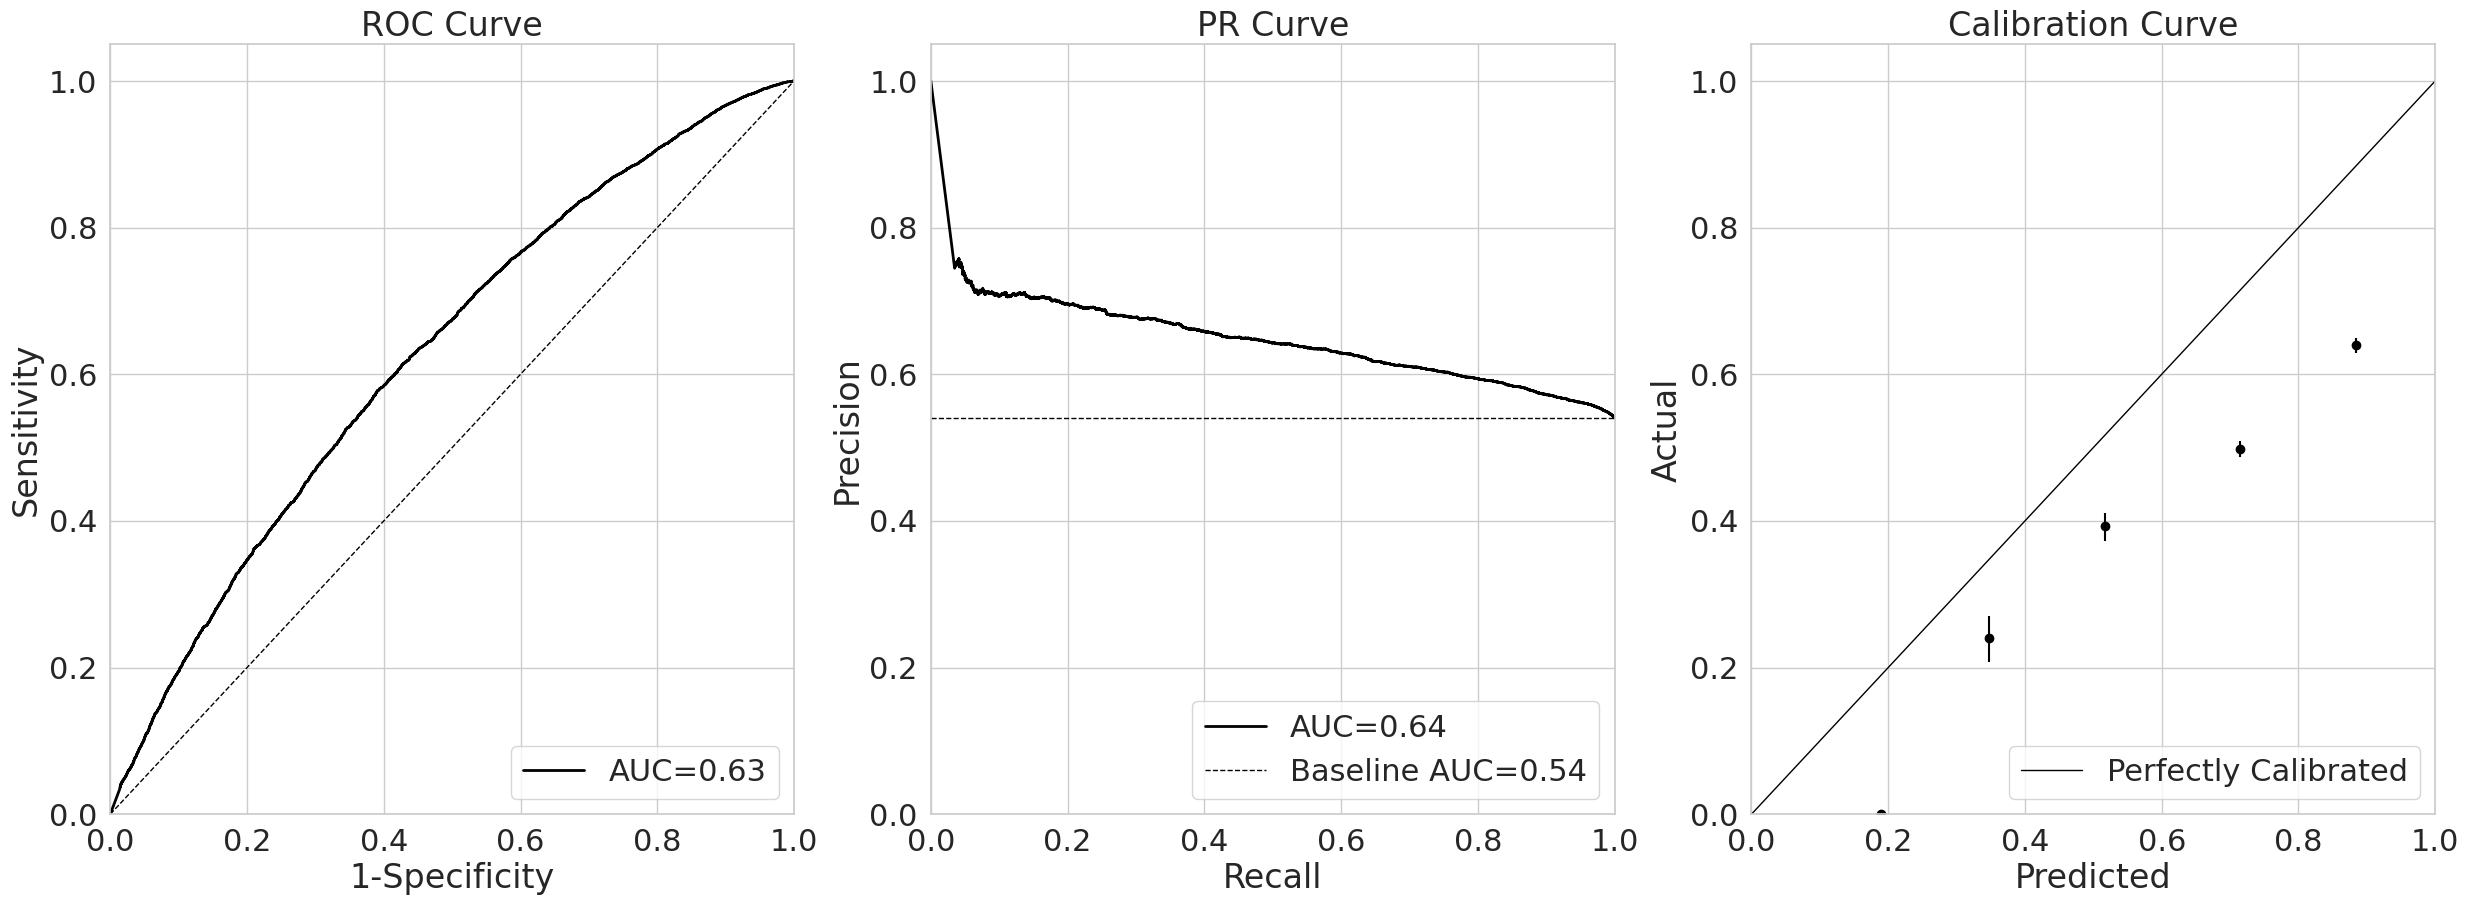

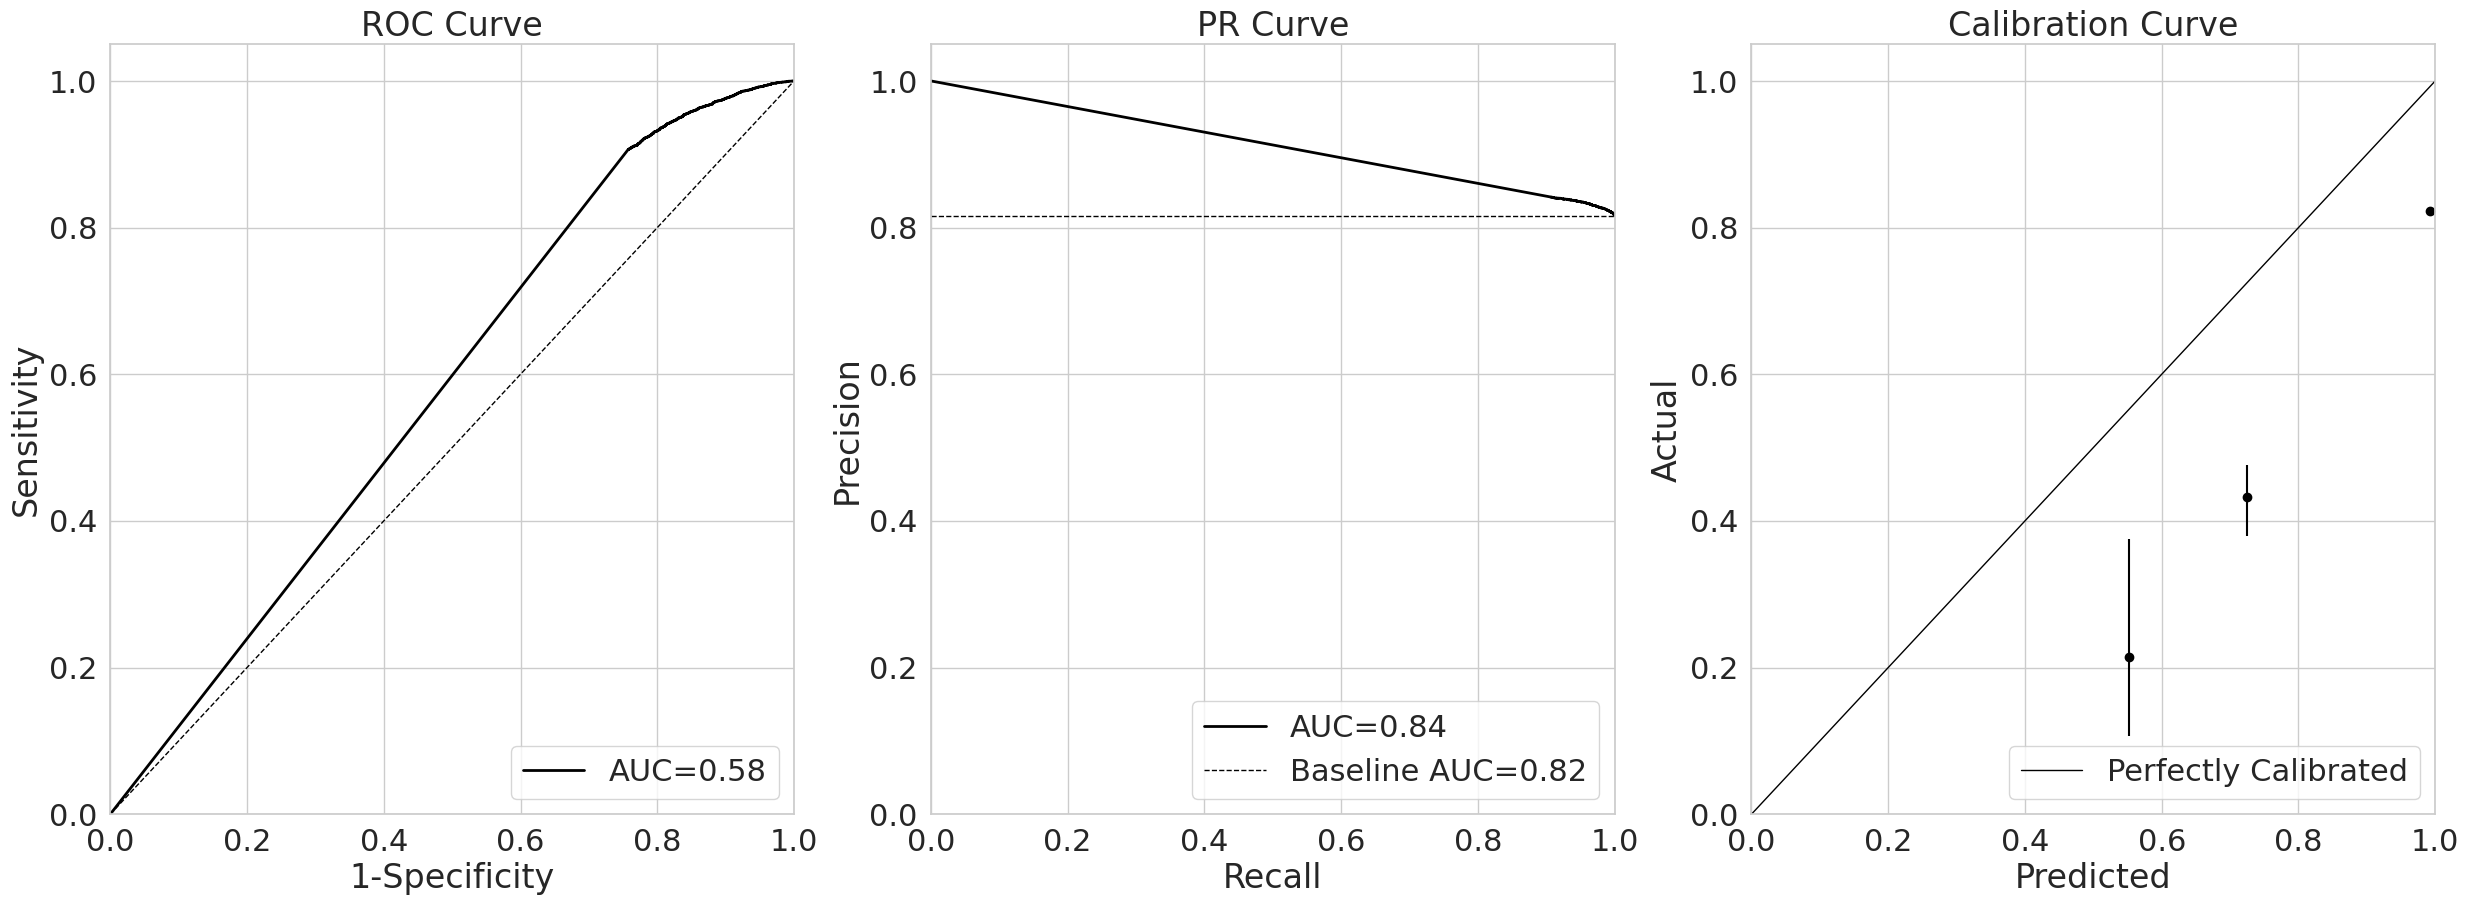

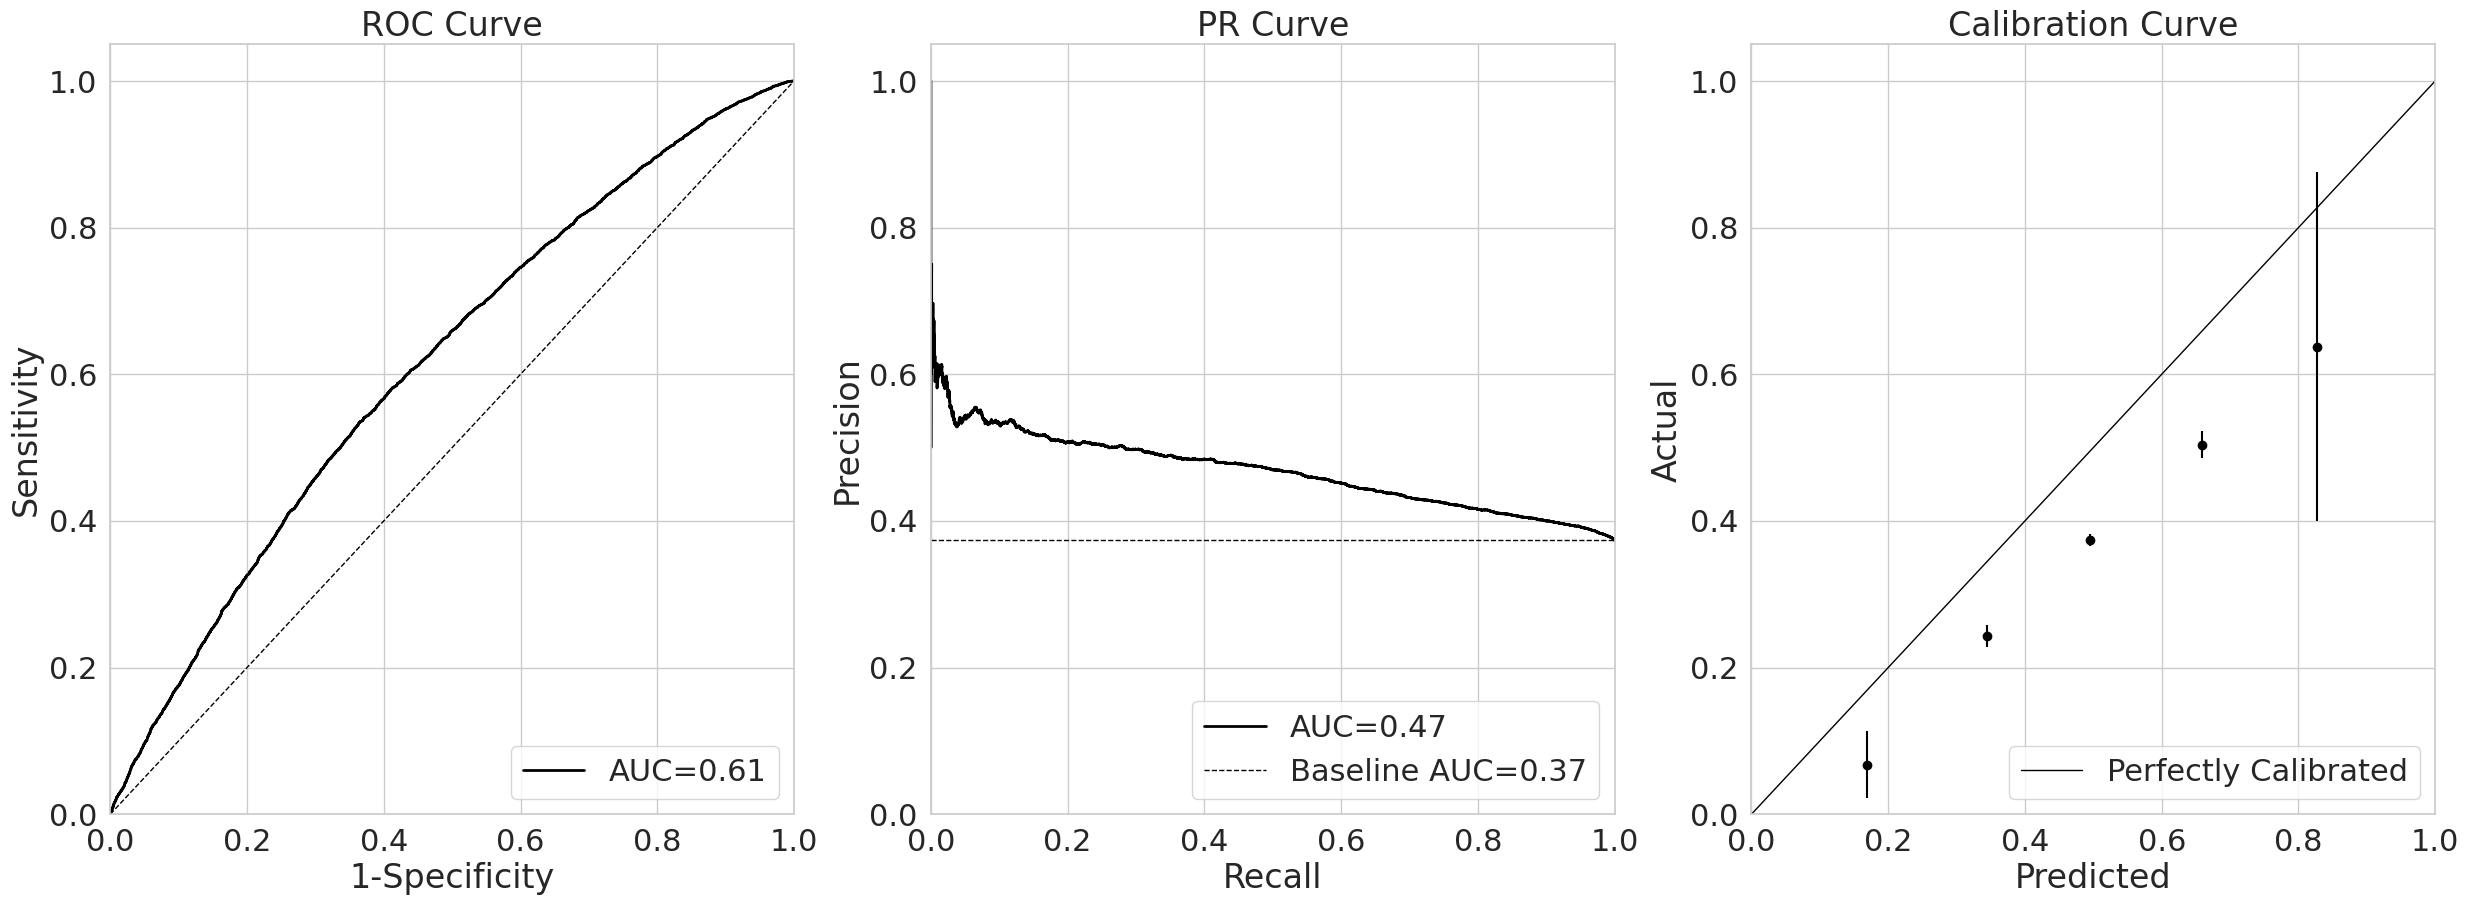

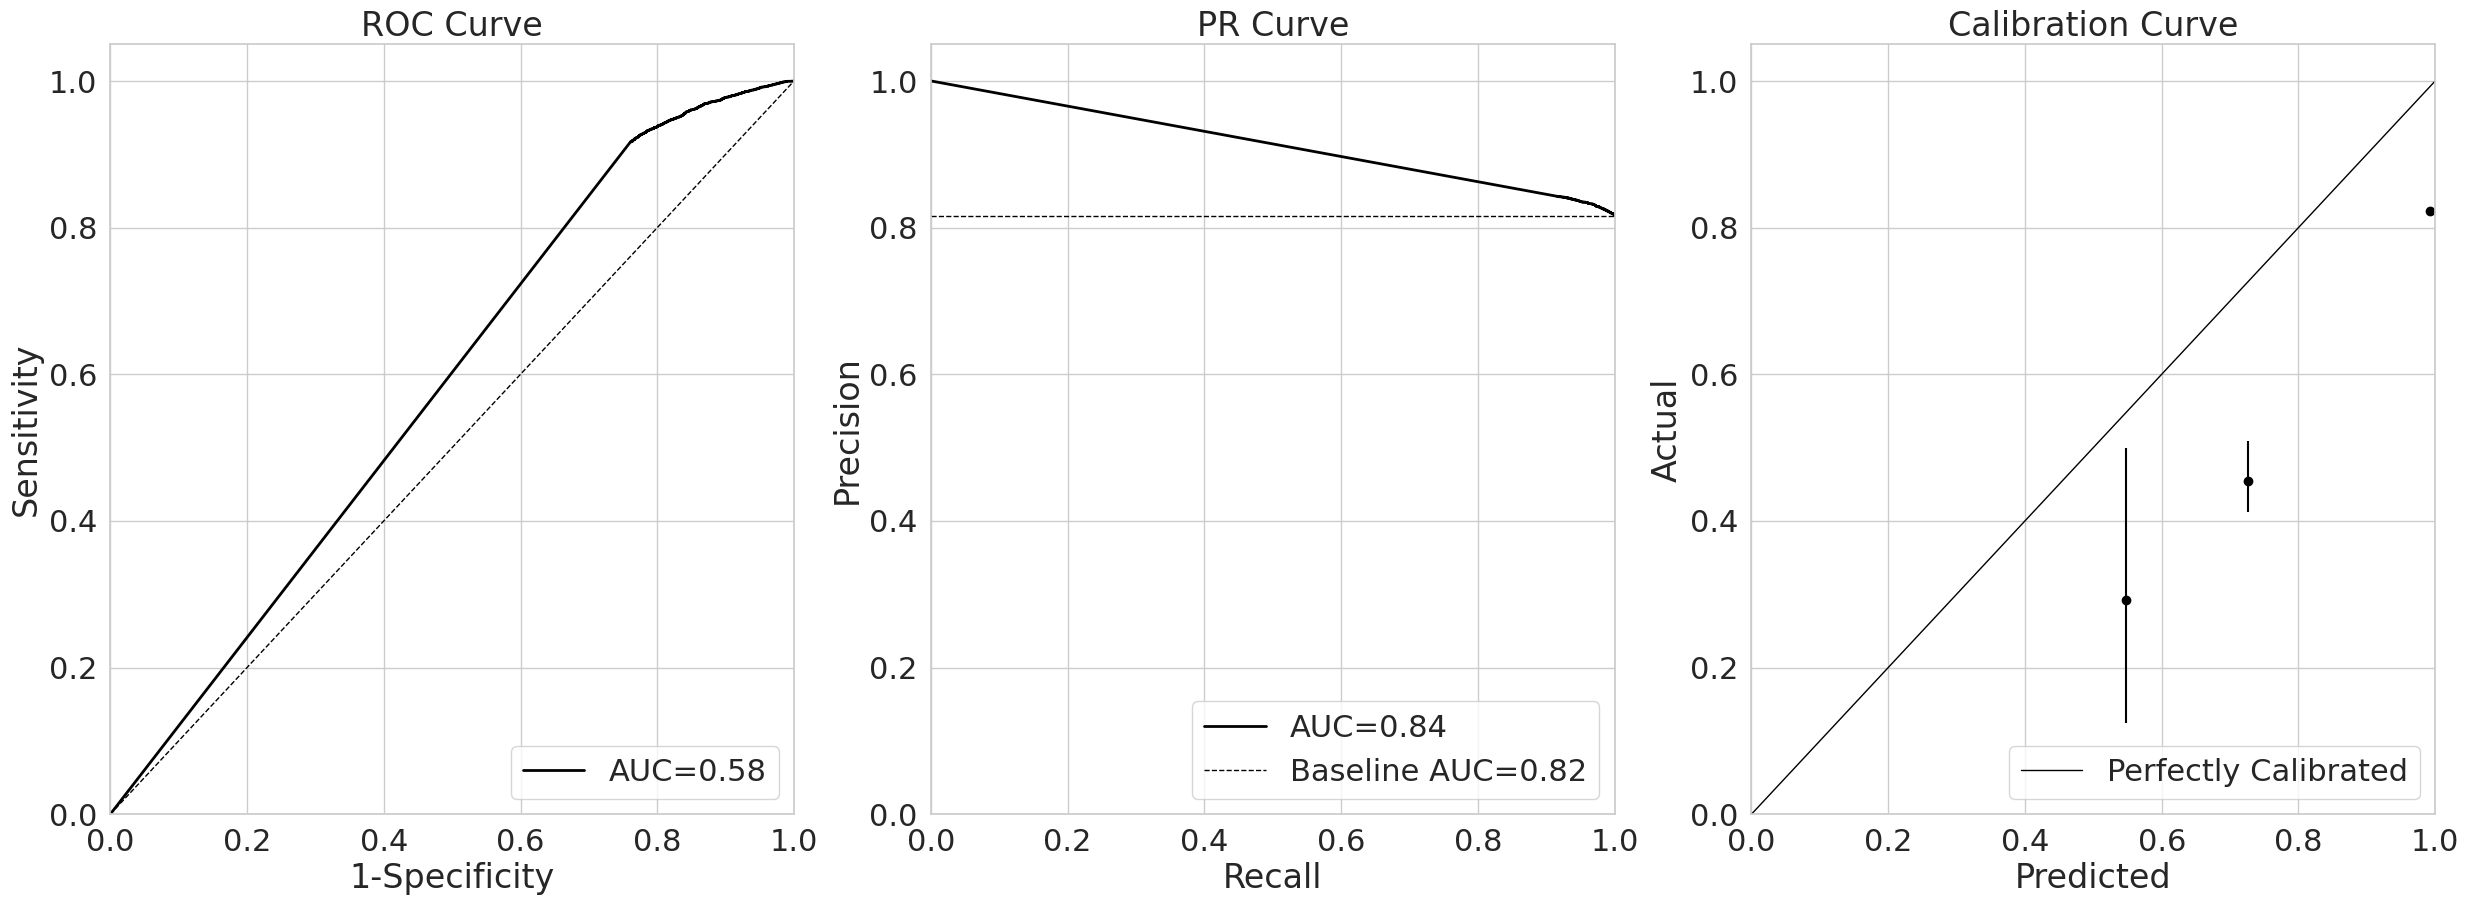

In [9]:
# with temperature scaling
tasks = ['label_PLT', 'label_HCT', 'label_WBC', 'label_HGB']
for task in tqdm(tasks):
    evalr = BinaryEvaluator(
        outdir=f"./{RUN_NAME}_artifacts/{task}_performance_artificats/",
        task_name=task
    )
    df_yhats = pd.read_csv(os.path.join(trainer.working_dir, f"{task}_classification_yhats.csv"))
    prediction_prob = temp_scaling(df_yhats.predictions.values, scale=1.4)
    evalr(df_yhats.labels, prediction_prob)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:40<00:00, 25.10s/it]


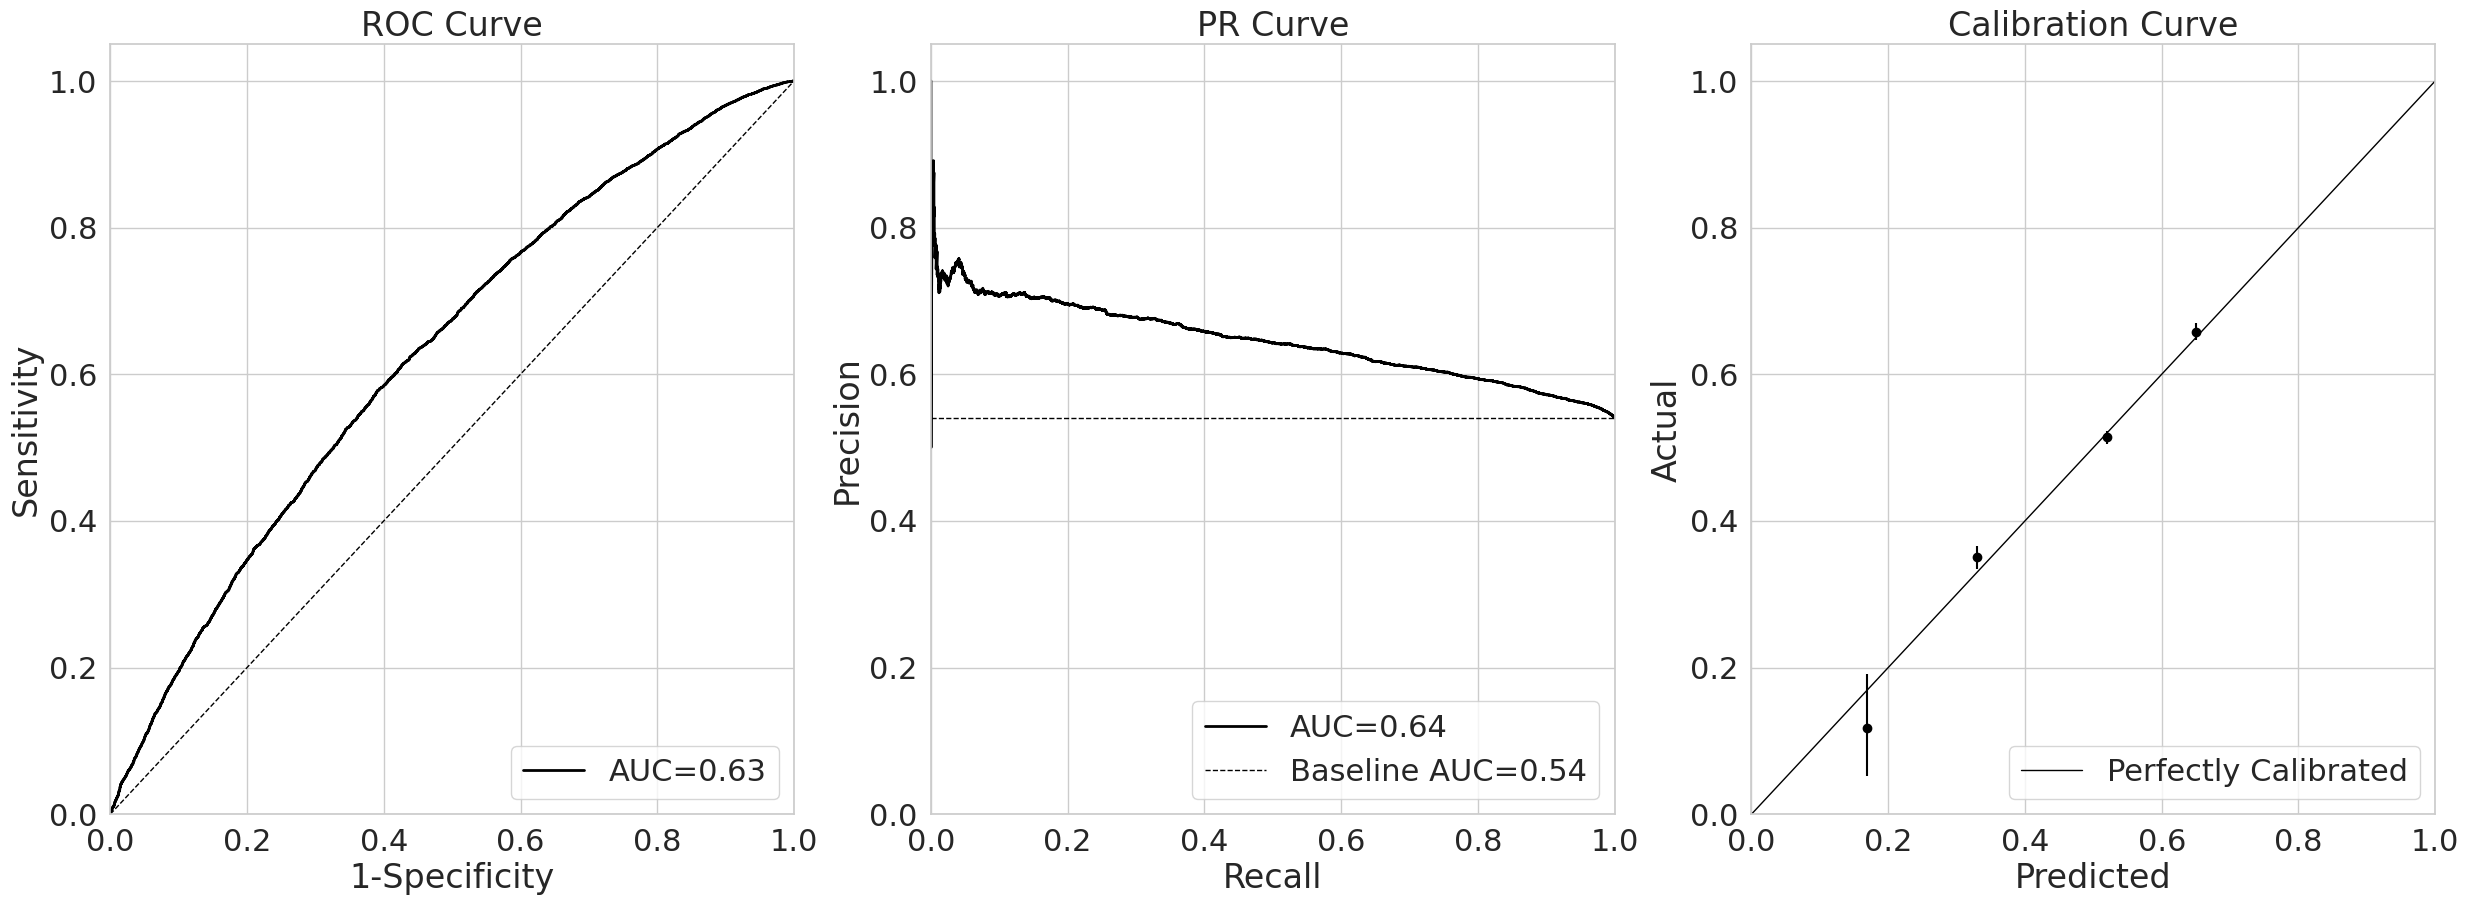

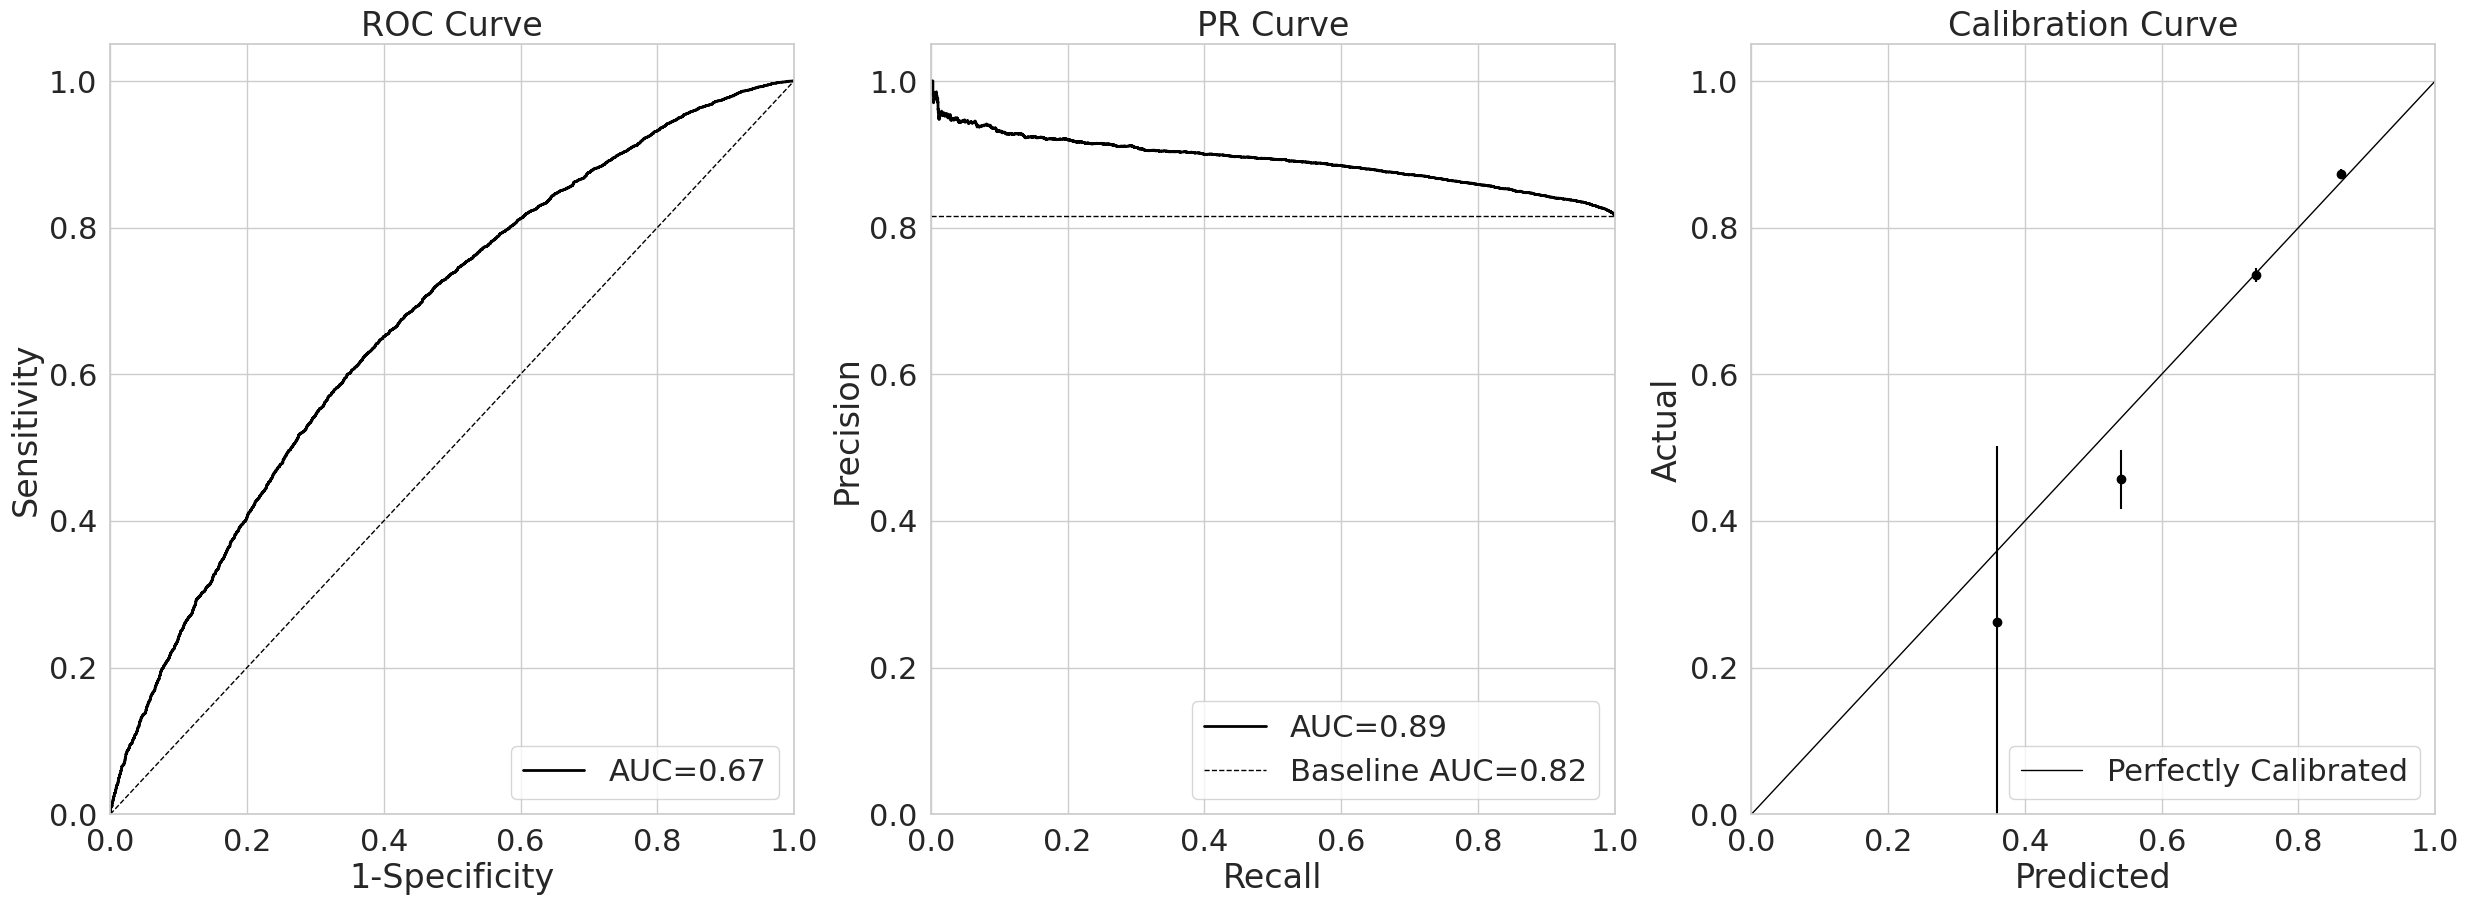

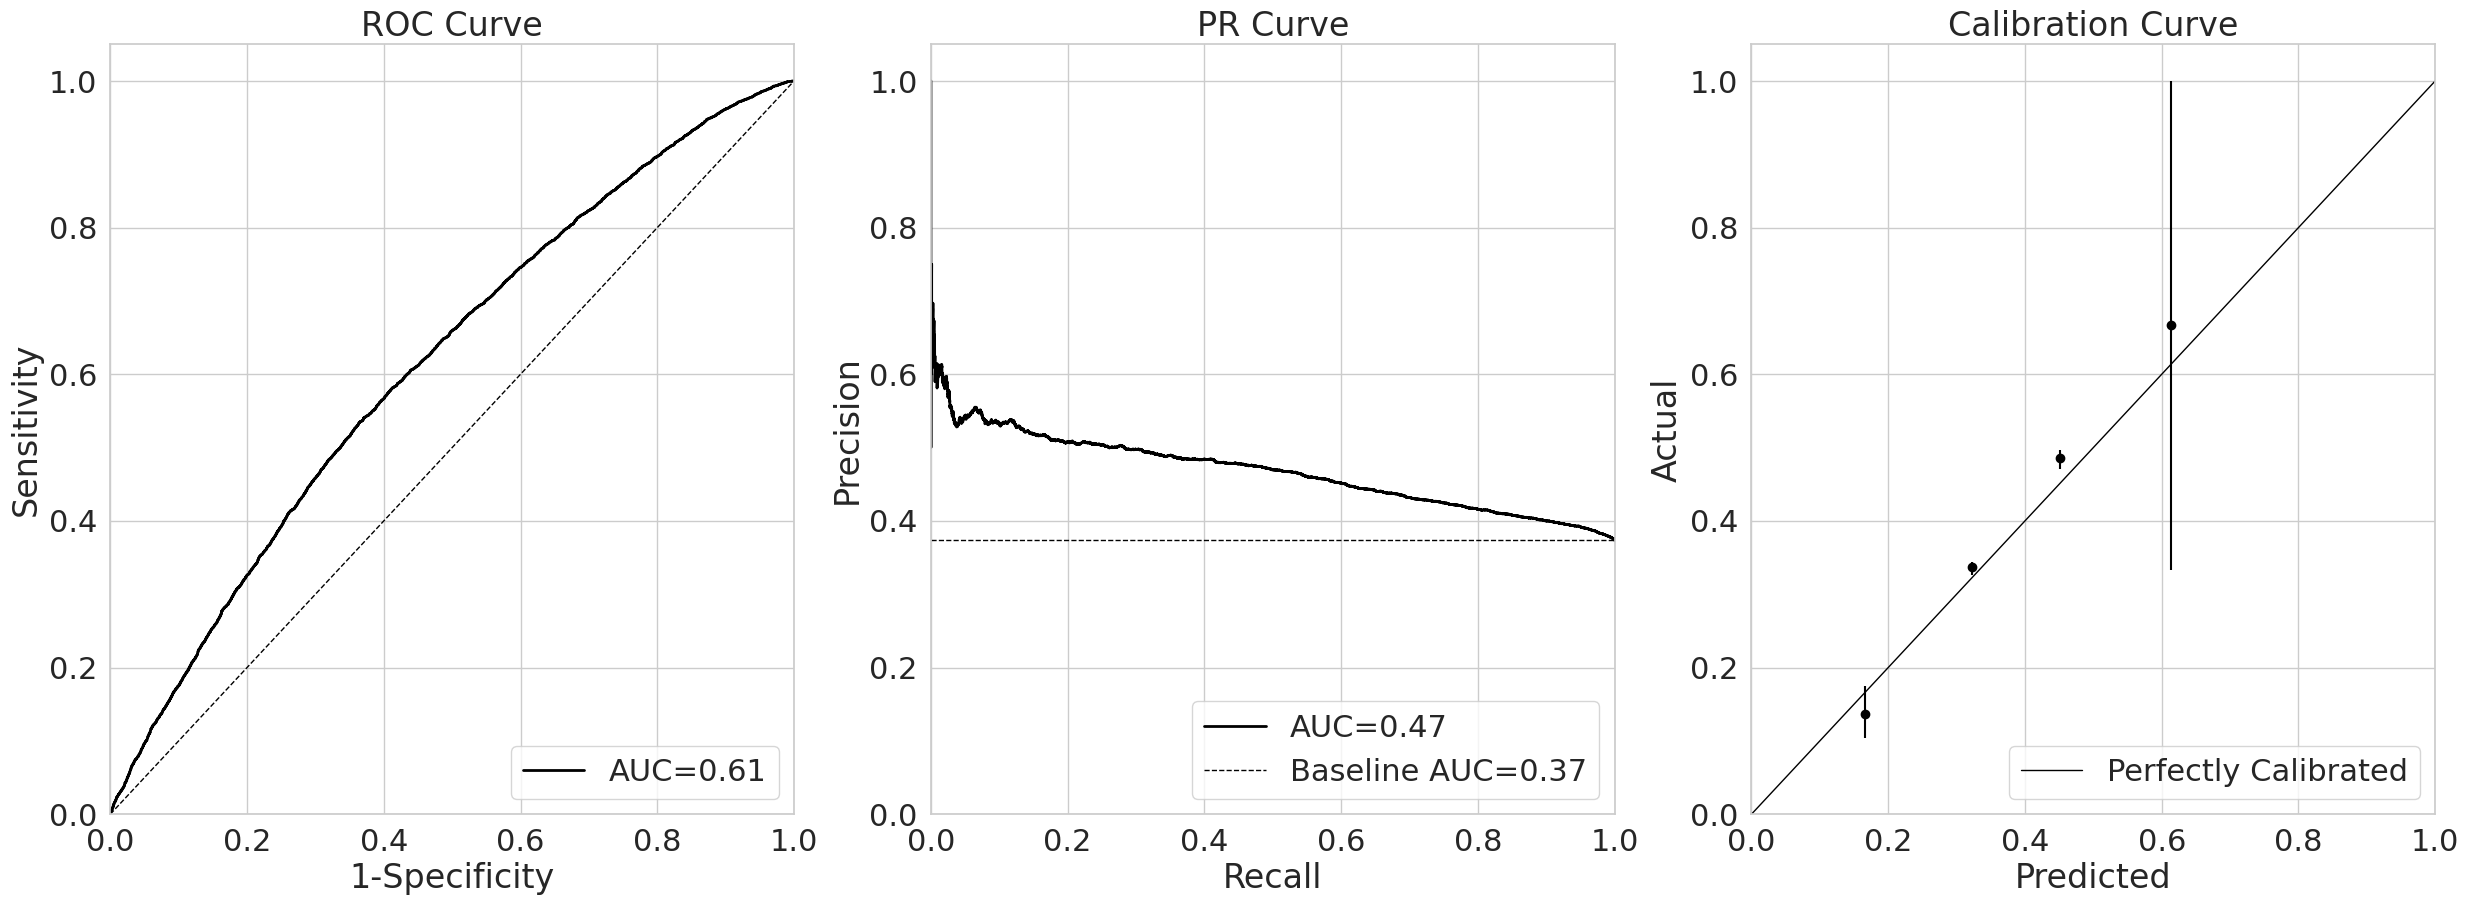

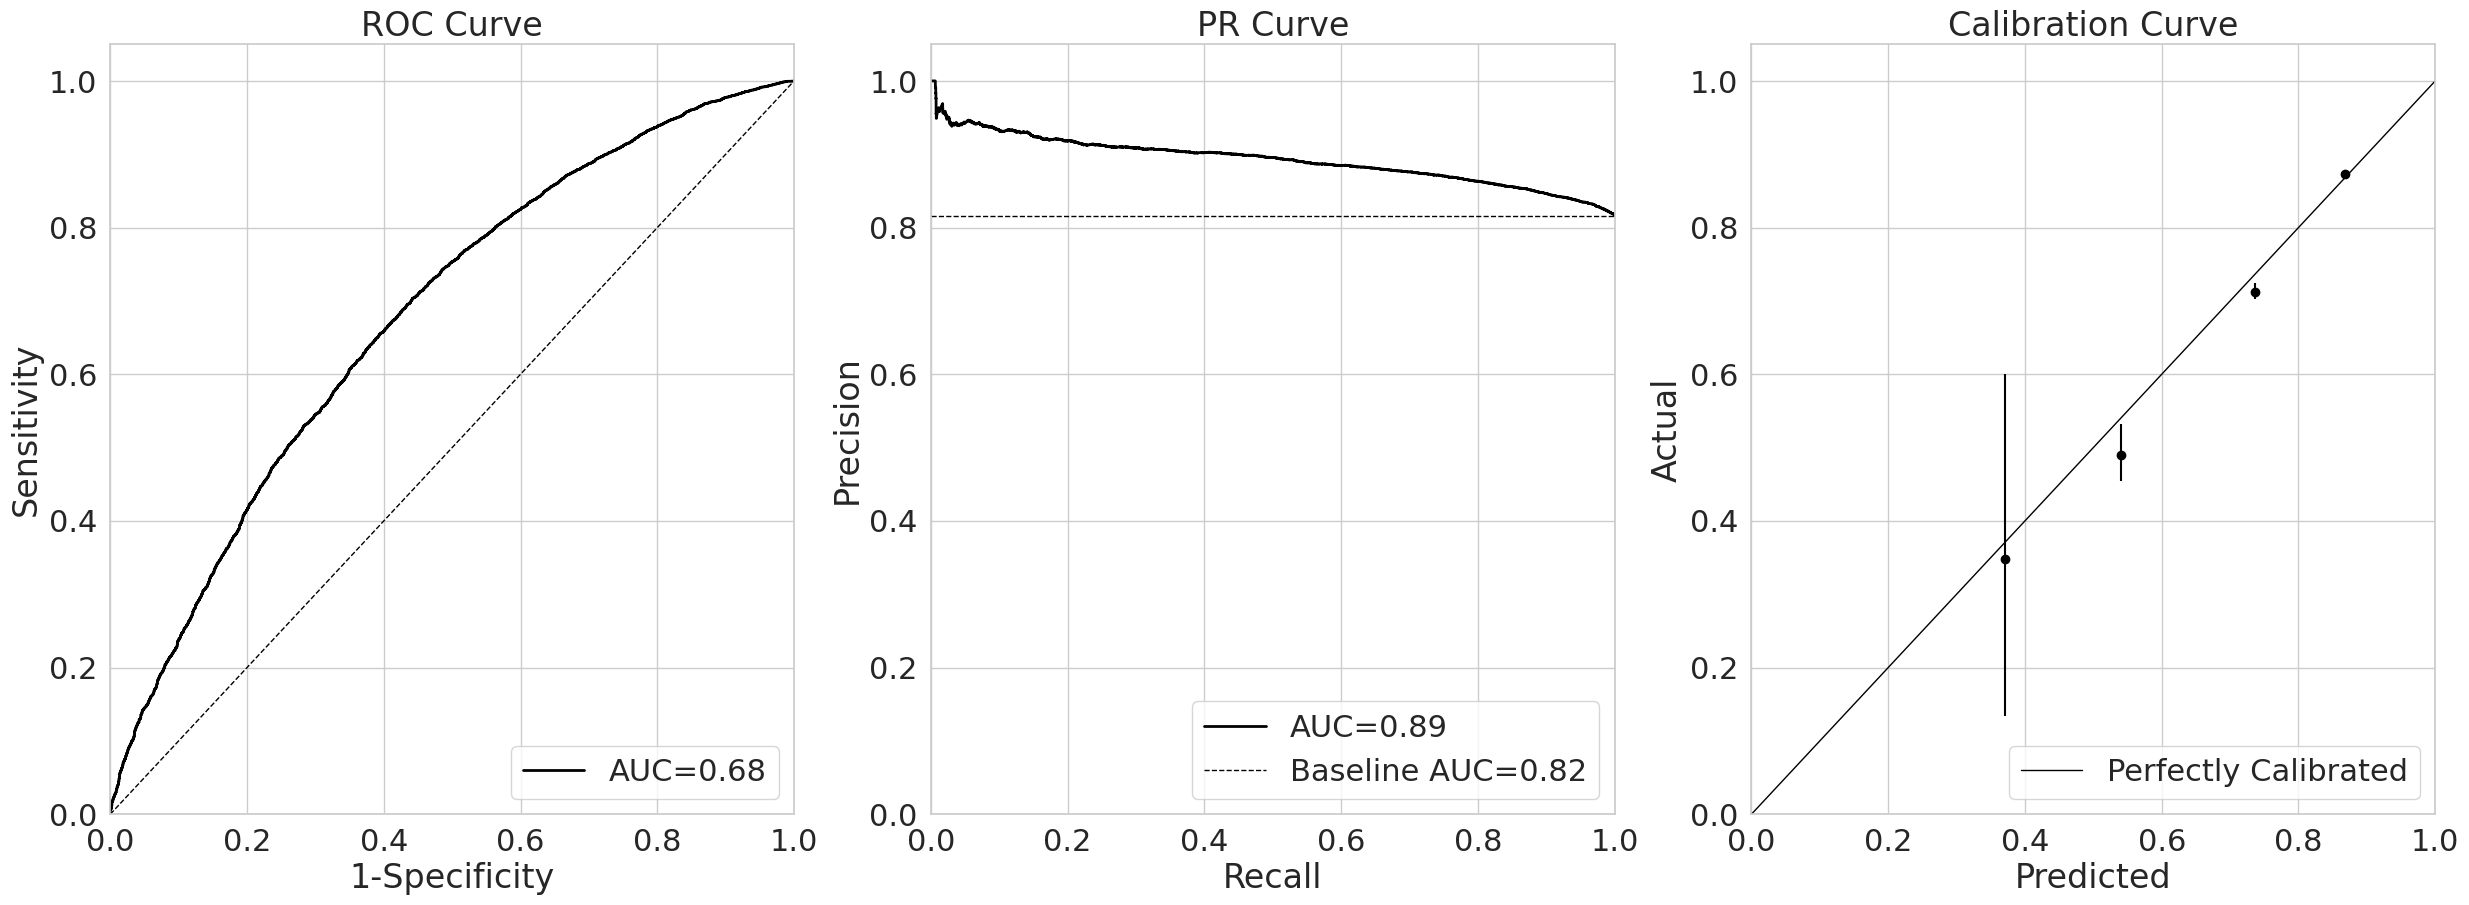

In [10]:
# without temperature scaling
tasks = ['label_PLT', 'label_HCT', 'label_WBC', 'label_HGB']
for task in tqdm(tasks):
    evalr = BinaryEvaluator(
        outdir=f"./{RUN_NAME}_artifacts/{task}_performance_artificats/",
        task_name=task
    )
    df_yhats = pd.read_csv(os.path.join(trainer.working_dir, f"{task}_classification_yhats.csv"))
    prediction_prob = temp_scaling(df_yhats.predictions.values)
    evalr(df_yhats.labels, prediction_prob)